# Standard imports

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
#from statistics import *
import seaborn as sns

#from scipy import stats
#from statistics import stdev

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping#, ModelCheckpoint

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout#, Flatten
from tensorflow.keras.layers import Input

# Check if running in Colab & Tensorflow version

In [0]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [0]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.2.0


# Define the problem to solve
- Do you view this as a Regression task? A Classification task? Justify your choice. 
  - This is a **regression task**, since we are predicting numerical (and continuous) output variables (i.e. returns).
- Define the Performance Metric that you think is appropriate. Justify your choice.
  - I will use **Mean Squared Error (MSE)** as my performance metric.
    - MSE is the average of squared differences between predictions and actual observations. 
    - Since the errors are squared before they are averaged,  MSE gives a relatively **high weight to large errors**. This means the MSE is useful when large errors are particularly undesirable (we of course want to predict stock returns as accurate as possible). 

- This is a **"many to many"** problem
  - sequence as input (a time series of features), sequence as output (a time series of 2-year predicted returns)

- To be precise, the "Stock Prediction" task involves: 
  - Training a many to many LSTM with examples from 2000-2013 data (each row as an example)
  - **Rather than predicting returns directly, I will predict Close first and then calculate predicted returns. The target is thus to predict the last-200-day returns of AAPL for a holdout directory (my holdout directory is 2015 & 2016 data)**
  - Features of a single example (i.e. a row) are the input of the series of predictions



# A.1 Get the data

In [0]:
# check current working directory
os.getcwd()

'/content/drive/My Drive'

In [0]:
# change to the current working directory of "data"
os.chdir('/content/drive/My Drive')
os.getcwd()

'/content/drive/My Drive'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# read data for all tickers
tickers = ['AAPL', 'ACN', 'ADBE', 'CRM', 'CSCO', 'FB', 'GOOG', 'IBM', 'INTC', 
           'MA','MSFT', 'NVDA', 'SPY', 'V', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 
           'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']

TRAIN_PATH = "./data/final_project/stock_prediction/train" 

for tick in tickers:
    data_file = tick +'.csv'
    exec('{} = pd.read_csv( os.path.join(TRAIN_PATH, data_file) )'.format(tick))

In [0]:
ACN

Dt  Adj Close   Close  Div  ...      High     Low    Open     Volume
0     2000-01-03        NaN     NaN  NaN  ...       NaN     NaN     NaN        NaN
1     2000-01-04        NaN     NaN  NaN  ...       NaN     NaN     NaN        NaN
2     2000-01-05        NaN     NaN  NaN  ...       NaN     NaN     NaN        NaN
3     2000-01-06        NaN     NaN  NaN  ...       NaN     NaN     NaN        NaN
4     2000-01-07        NaN     NaN  NaN  ...       NaN     NaN     NaN        NaN
...          ...        ...     ...  ...  ...       ...     ...     ...        ...
4272  2016-12-23   111.7080  117.48  0.0  ...  118.2100  117.11  117.40  1697200.0
4273  2016-12-27   111.7746  117.55  0.0  ...  118.4817  117.21  117.36  1546300.0
4274  2016-12-28   110.8808  116.61  0.0  ...  118.0000  116.09  118.00  1797700.0
4275  2016-12-29   111.2611  117.01  0.0  ...  117.9800  116.51  116.98  1633900.0
4276  2016-12-30   111.3752  117.13  0.0  ...  117.9500  116.59  117.56  1739500.0

[4277 rows x 9 columns]

# A.2 Have a look

In [0]:
AAPL.head()

Dt  Adj Close    Close  Div  ...     High      Low      Open       Volume
0  2000-01-03     3.4785  111.938  0.0  ...  112.500  101.688  104.8750  133949200.0
1  2000-01-04     3.1852  102.500  0.0  ...  110.625  101.188  108.2500  128094400.0
2  2000-01-05     3.2318  104.000  0.0  ...  110.563  103.000  103.7500  194580400.0
3  2000-01-06     2.9521   95.000  0.0  ...  107.000   95.000  106.1183  191993200.0
4  2000-01-07     3.0920   99.500  0.0  ...  101.000   95.500   96.5000  115183600.0

[5 rows x 9 columns]

In [0]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dt         4277 non-null   object 
 1   Adj Close  4277 non-null   float64
 2   Close      4277 non-null   float64
 3   Div        4277 non-null   float64
 4   Factor     4277 non-null   float64
 5   High       4277 non-null   float64
 6   Low        4277 non-null   float64
 7   Open       4277 non-null   float64
 8   Volume     4277 non-null   float64
dtypes: float64(8), object(1)
memory usage: 300.9+ KB


- no null entry 
- all number entries are float64

In [0]:
AAPL.describe()

Adj Close        Close  ...         Open        Volume
count  4277.000000  4277.000000  ...  4277.000000  4.277000e+03
mean     34.065846   170.450354  ...   170.528689  1.299660e+08
std      36.698987   173.484604  ...   173.604272  9.970883e+07
min       0.815400    13.120000  ...    12.990000  9.835000e+06
25%       3.115300    39.759000  ...    39.530000  6.363350e+07
50%      16.948300   106.745000  ...   106.959000  1.016484e+08
75%      62.413600   222.250000  ...   220.010000  1.679636e+08
max     122.771400   702.100000  ...   702.410000  1.855410e+09

[8 rows x 8 columns]

In [0]:
AAPL.shape

(4277, 9)

In [0]:
# see how a single example (i.e. a row) looks like
AAPL.iloc[1]

Dt            2000-01-04
Adj Close         3.1852
Close              102.5
Div                    0
Factor                 1
High             110.625
Low              101.188
Open              108.25
Volume       1.28094e+08
Name: 1, dtype: object

# A.3 Define a performance metrics
- I will use MSE as I explained above
  - accuracy is meaningful only for classification problems; for regression (i.e. numeric prediction) ones, accuracy is meaningless.

# **Preliminary data prep
 For all files imported:
  - 1) add Return
  - 2) add 7-day and 30-day Moving Average
  - 2) set 'Dt' as index 

*****Note: 
  - In the calculation of the 7-day moving average, the closing prices from day 1 to day 7 are used in the summation. 
  - **However, we should avoid looking into the future**. 
  - Thus, I will use the 7-day MA (calculated using prices of day 1-7) for day 8, i.e.  `MA7` of day 8 is based on prices in the past (day 1-7) only.


In [0]:
def preliminary_prep(df):
  df['Return'] = df['Close'].pct_change()
  
  df['MA7'] = df['Close'].rolling(7).mean()
  df['MA30'] = df['Close'].rolling(30).mean()
  df['MA7'] = df['MA7'].shift(1, axis = 0) 
  df['MA30'] = df['MA30'].shift(1, axis = 0) 
  
  df.set_index('Dt', inplace = True)

  return df

In [0]:
# a list of dataframes
dfs = [AAPL, ACN, ADBE, CRM, CSCO, FB, GOOG, IBM, INTC, 
       MA, MSFT, NVDA, SPY, V, XLB, XLE, XLF, XLI, XLK, 
       XLP, XLRE, XLU, XLV, XLY]

# preliminary_prep for all tickers
for df in dfs:
    df = preliminary_prep(df)

In [0]:
AAPL.head(8)

Adj Close    Close  Div  ...    Return         MA7  MA30
Dt                                   ...                            
2000-01-03     3.4785  111.938  0.0  ...       NaN         NaN   NaN
2000-01-04     3.1852  102.500  0.0  ... -0.084315         NaN   NaN
2000-01-05     3.2318  104.000  0.0  ...  0.014634         NaN   NaN
2000-01-06     2.9521   95.000  0.0  ... -0.086538         NaN   NaN
2000-01-07     3.0920   99.500  0.0  ...  0.047368         NaN   NaN
2000-01-10     3.0376   97.750  0.0  ... -0.017588         NaN   NaN
2000-01-11     2.8822   92.750  0.0  ... -0.051151         NaN   NaN
2000-01-12     2.7094   87.188  0.0  ... -0.059968  100.491143   NaN

[8 rows x 11 columns]

- The first 7 rows of MA7 and the first 30 rows of MA30 are NaN, so we need to fillna in Recipe C.1 Cleaning if we want to use these two features.

# A.4 Create a test set
- Training set: from 2000-01-03 to 2013-12-31
- Validation set: from 2014-01-02 to 2014-12-31
- Test set: from 2015-01-02 to 2016-12-30 (2 years)



In [0]:
# split every dataframe into three subsets (train, valid, test)

def split_sets (df):
  train = df.loc[:'2013-12-31', :]  
  valid = df.loc['2014-01-02':'2014-12-31', :]
  test = df.loc['2015-01-02':'2016-12-30', :]

  return  train, valid, test

In [0]:
# create train, valid, test for AAPL
AAPL_train, AAPL_valid, AAPL_test = split_sets (AAPL)

In [0]:
AAPL_train.head(8)

Adj Close    Close  Div  ...    Return         MA7  MA30
Dt                                   ...                            
2000-01-03     3.4785  111.938  0.0  ...       NaN         NaN   NaN
2000-01-04     3.1852  102.500  0.0  ... -0.084315         NaN   NaN
2000-01-05     3.2318  104.000  0.0  ...  0.014634         NaN   NaN
2000-01-06     2.9521   95.000  0.0  ... -0.086538         NaN   NaN
2000-01-07     3.0920   99.500  0.0  ...  0.047368         NaN   NaN
2000-01-10     3.0376   97.750  0.0  ... -0.017588         NaN   NaN
2000-01-11     2.8822   92.750  0.0  ... -0.051151         NaN   NaN
2000-01-12     2.7094   87.188  0.0  ... -0.059968  100.491143   NaN

[8 rows x 11 columns]

# B: Exploratory Data Analysis (EDA)
- EDA on `AAPL_train` only, as we should avoid looking into future datasets

1. plot all "price" data


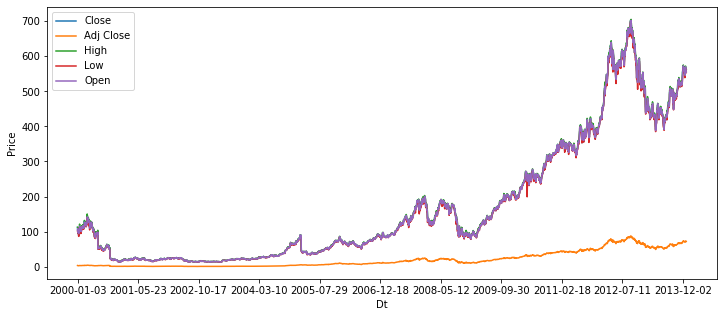

In [0]:
plt.figure(figsize = (12,5))
plt.plot(AAPL_train['Close'], label = 'Close')
plt.plot(AAPL_train['Adj Close'], label = 'Adj Close')
plt.plot(AAPL_train['High'], label = 'High')
plt.plot(AAPL_train['Low'], label = 'Low')
plt.plot(AAPL_train['Open'], label = 'Open')
plt.xticks(np.arange(0, 3521, step=350))
plt.xlabel('Dt')
plt.ylabel('Price')
plt.legend()
plt.show()

- Close, High, Low and Open all have a very similar trend, **while Adj Close is way lower. Maybe because it's on a different scale**. Let's take a closer look next.
- **Since High, Low and Open are so similar to Close, they might not be very useful in training the model. They fail to provide additional information but are very likely to create "noise". --> I will not use them as features for training**.

  - Close: simply the cash value of stock 
  - Adj Close: reflects the closing price of the stock in relation to other stock attributes, a more technically accurate reflection of the true value
    - Although Adj Close is a more accurate reflection, Return is calculated from Close. Using Adj Close which is on a smaller scale might cause inaccurate predictions. Check Model5 to see how Adj Close leads to less accurate predictions.

2. Let's take a closer look at Close vs. Adj Close. Plot them on primary and secondary axes.

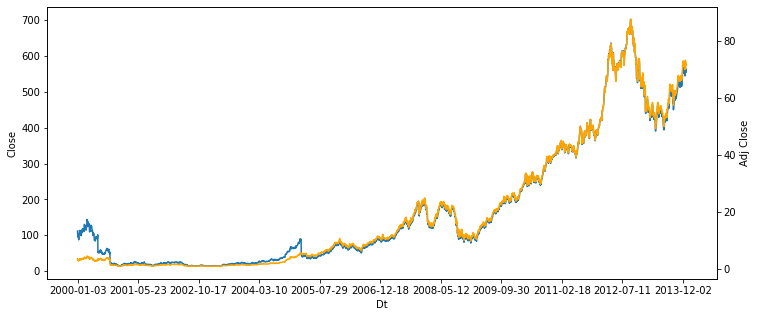

In [0]:
fig,ax1 = plt.subplots(figsize = (12, 5))
ax1.plot(AAPL_train['Close'])
plt.xlabel('Dt')
plt.ylabel('Close')

ax2 = ax1.twinx()
ax2.plot(AAPL_train['Adj Close'], color ='orange' )
plt.ylabel('Adj Close')
plt.xticks(np.arange(0, 3521, step=350))
plt.show()

- It turns out to be that Adj Close and Close have very similar trend as well.

3. Let's then check Close vs. Return:

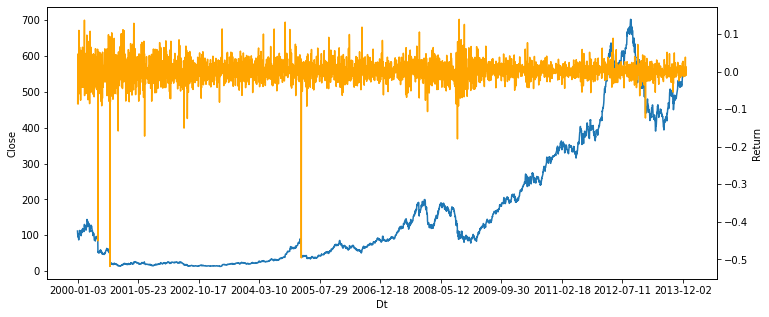

In [0]:
fig,ax1 = plt.subplots(figsize = (12, 5))
ax1.plot(AAPL_train['Close'])
plt.xlabel('Dt')
plt.ylabel('Close')

ax2 = ax1.twinx()
ax2.plot(AAPL_train['Return'], color ='orange' )
plt.ylabel('Return')
plt.xticks(np.arange(0, 3521, step=350))
plt.show()

- Obviously, sudden drops in Return are associated with low Close and high Return is associated with high Close.
- In most of the days, return is between 0.1 and -0.1.
- **Close has a strong correlation with Return, thus I will use it as a feature**. 
  - make sure to avoid look-ahead issue

4. Check Volume vs. Close


In [0]:
fig,ax1 = plt.subplots(figsize = (12, 5))
ax1.plot(AAPL_train['Volume'])
plt.xlabel('Dt')
plt.ylabel('Volume')

ax2 = ax1.twinx()
ax2.plot(AAPL_train['Close'], color ='orange' )
plt.ylabel('Close')
plt.xticks(np.arange(0, 3521, step=350))
plt.show()

- Low Close is associated with high volume, which means that people buy more stocks when the price is low.  
- Although they have a good correlation, volume is on a different scale from Close. I'm concerned that it might not be a good feature to use for predicting Close. Check Model2 to see how Volume does not help to predict at all.

5. Check Div vs. Return
  - First, check when did Apple pay dividends
  - Next, plot Div vs. Return during the "dividend-paying" period to see if paying dividends affects stock return

In [0]:
AAPL_train['Div'].nlargest(n=10)

Dt
2013-05-09    0.4357
2013-08-08    0.4357
2013-11-06    0.4357
2012-08-09    0.3786
2012-11-07    0.3786
2013-02-07    0.3786
2000-01-03    0.0000
2000-01-04    0.0000
2000-01-05    0.0000
2000-01-06    0.0000
Name: Div, dtype: float64

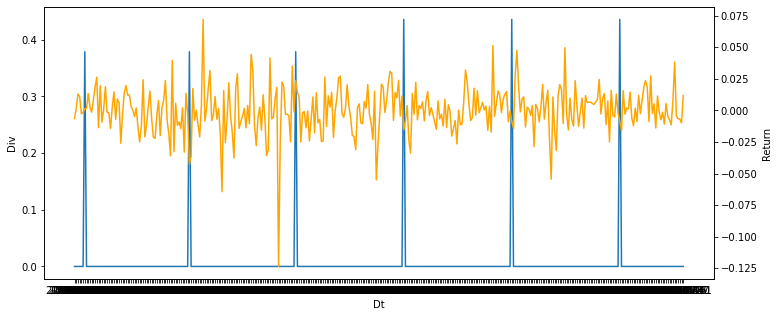

In [0]:
fig,ax1 = plt.subplots(figsize = (12, 5))
ax1.plot(AAPL_train['Div'].loc['2012-08-01': '2013-12-31'])
plt.xlabel('Dt')
plt.ylabel('Div')

ax2 = ax1.twinx()
ax2.plot(AAPL_train['Return'].loc['2012-08-01': '2013-12-31'], color ='orange')
plt.ylabel('Return')
plt.show()

- **Before**: increase/high in Return before actual dividend-paying days. 
  - company first declare the dividend amount and the pay day. It also announces ***ex-dividend date***, the last day when shares can be purchased to receive the dividend 
  - The declaration of a dividend encourages investors to purchase stocks before the ex-dividend date. This causes the price of a stock to increase in the days leading up to the ex-dividend date --> increase of Return

- **On the dividend-paying day**: decrease of return
 - dividend increases # of shares outstanding while the value of the company remains stable --> dilutes the book value per common share --> reduced price --> reduced return

- **After**: slight increase of return
  - paying dividend shows investors a good financial performance of a company, so more investors want to invest in that firm, driving up the price and thus the return

- **Div is zero most of the time and it only influence Close and Return for a very short period during the dividend-paying activities. It does not contribute to the overall trend of Close and Return, so I will not use it as a feature.**

6. Check Factor vs. Return
  - First, check the dates when Factor was not one. 
  - Next, plot Factor vs. Return.

In [0]:
AAPL_train['Factor'].nlargest()

Dt
2000-06-21    2.0
2005-02-28    2.0
2000-01-03    1.0
2000-01-04    1.0
2000-01-05    1.0
Name: Factor, dtype: float64

In [0]:
fig,ax1 = plt.subplots(figsize = (12, 5))
ax1.plot(AAPL_train['Factor'])
plt.xlabel('Dt')
plt.ylabel('Factor')

ax2 = ax1.twinx()
ax2.plot(AAPL_train['Return'], color ='orange')
plt.ylabel('Return')
plt.show()

- 2000-06-21: Apple stock splitted. Shares doubled --> price halfed.
- 2005-02-28: another two-for-one stock split
- So, a factor of two is used to adjust for a 2-1 stock split, an event that halves stock price, leading to a drastic drop in return.

- **Stock split is a very rare event, so Factor only influence Close and Return for a few specific days. It does not contribute to the overall trend, so I will not use it as a feature.**


7. Check MA7, MA30 vs. Close

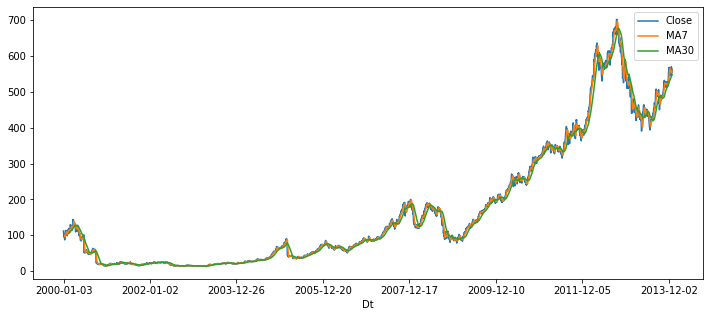

In [0]:
# plot
AAPL_train[['Close', 'MA7', 'MA30']].plot(figsize = (12,5))

 - Both MA7 and MA30 represent a trend that is consistent with Close.
 - **However, MA30 has a greater degree of lag than MA7. MA30 would cause the predictions to be lagged and thus less accurate. So I will only use include MA7 as a feature**. 

**Summary: I am interested in using Close, Adj Close, Volume, MA7 as features. I will test each of them in the next sections.**

# Baseline
- As I am working on a regression problem, I will use a central tendency measure as the result for all predictions
- To be more specific, here I use **7-day moving average (MA7)** to identify the trend direction. 
  - Moving Average helps smooth out price action by filtering out the “noise” from random short-term price fluctuations.
- First, plot real Close vs. predicted Close (represented by MA7)
- Next,  plot real Return vs. predicted Return 
  

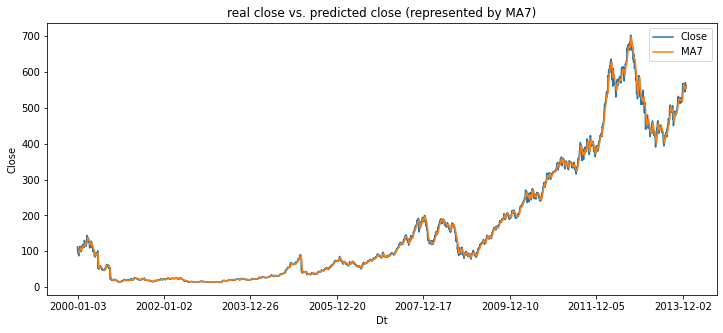

In [0]:
AAPL_train[['Close', 'MA7']].plot(figsize = (12,5))
plt.title('real close vs. predicted close (represented by MA7)')
plt.ylabel('Close')
plt.show()

In [0]:
predicted_return = AAPL_train['MA7'].pct_change()
real_return = AAPL_train['Return']

In [0]:
plt.figure(figsize = (12,5))
plt.plot(real_return, label = 'real')
plt.plot(predicted_return, label = 'predicted')

plt.xticks(np.arange(0, 3521, step=350))
plt.xlabel('Dt')
plt.ylabel('Return')
plt.title('real return vs. predicted return (calculated from MA7)')
plt.legend()
plt.show()

- MA7 seems like a good prediction for Close. The two are very consistent.
- Although predicted return approximately follows the trend of real return, it does not predict well extreme return values.
- **Next goal: introduce LSTM model to improve the prediction of Return**


# Model1 (LSTM using AAPL MA7)

## create x, y
- In the training set, when predicting Close for time *t*, I can only use features occuring before time *t*, not the actual features at time *t*. So, `y` must be one day later than `x`. 
  - That means, if my `x_train` is from **2000-01-03 to 2013-12-31**, my `y_train` needs to be from **2000-01-04 to 2014-01-02**. 
- In model1, I will use the only one feature AAPL's `MA7` from baseline to avoid too much noise and overfitting

In [0]:
# y_train, y_valid and y_test are the same for all models
y_train = AAPL['Close'].loc['2000-01-04':'2014-01-02']
y_valid = AAPL_valid['Close']
y_test = AAPL_test['Close'] 

In [0]:
# as outputs, they need to be reshaped into [samples, 1]
y_train = np.array(y_train).reshape(-1, 1)
y_valid = np.array(y_valid).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)


In [0]:
y_train.shape, y_valid.shape, y_test.shape

((3521, 1), (252, 1), (504, 1))

In [0]:
# create x
x_train1 = pd.DataFrame(AAPL_train['MA7'])
x_valid1 = pd.DataFrame(AAPL_valid['MA7'])
x_test1 = pd.DataFrame(AAPL_test['MA7'])

In [0]:
x_train1

MA7
Dt                    
2000-01-03         NaN
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
...                ...
2013-12-24  554.465714
2013-12-26  556.357143
2013-12-27  557.271429
2013-12-30  558.000000
2013-12-31  558.535714

[3521 rows x 1 columns]

In [0]:
x_valid1

MA7
Dt                    
2014-01-02  560.901429
2014-01-03  561.488571
2014-01-06  557.330000
2014-01-07  553.938571
2014-01-08  550.529714
...                ...
2014-12-24  110.612857
2014-12-26  111.153571
2014-12-29  112.188571
2014-12-30  112.831429
2014-12-31  112.812857

[252 rows x 1 columns]

In [0]:
x_test1

MA7
Dt                    
2015-01-02  112.612857
2015-01-05  112.097143
2015-01-06  111.198571
2015-01-07  110.377143
2015-01-08  109.485714
...                ...
2016-12-23  116.274286
2016-12-27  116.464286
2016-12-28  116.670000
2016-12-29  116.782857
2016-12-30  116.795714

[504 rows x 1 columns]

## C.1 Cleaning
- Only x_train1 has NaN
- fill NaN in MA7 with actual Close
  - because `y_train1` is one day later than `x_train1`, filling NaN with Close will not cause the look-ahead issue

In [0]:
np.sum(np.isnan(x_train1['MA7']))

7

In [0]:
for i in range(7):
  x_train1['MA7'][i] = AAPL_train['Close'][i]

In [0]:
np.sum(np.isnan(x_train1['MA7']))

0

In [0]:
x_train1

MA7
Dt                    
2000-01-03  111.938000
2000-01-04  102.500000
2000-01-05  104.000000
2000-01-06   95.000000
2000-01-07   99.500000
...                ...
2013-12-24  554.465714
2013-12-26  556.357143
2013-12-27  557.271429
2013-12-30  558.000000
2013-12-31  558.535714

[3521 rows x 1 columns]

## C.2: Handling non-numeric features/targets
- N/A

## C.3 Transformation
- reshape input to be 3D [samples, timesteps, features]

In [0]:
x_train1.shape, x_valid1.shape, x_test1.shape

((3521, 1), (252, 1), (504, 1))

In [0]:
def reshape_3D (x_train, x_valid, x_test):
  x_train = np.array(x_train).reshape(x_train.shape[0], 1, x_train.shape[1])
  x_valid = np.array(x_valid).reshape(x_valid.shape[0], 1, x_valid.shape[1])
  x_test = np.array(x_test).reshape(x_test.shape[0], 1, x_test.shape[1])

  return x_train, x_valid, x_test

In [0]:
x_train1, x_valid1, x_test1 = reshape_3D(x_train1, x_valid1, x_test1)

In [0]:
x_train1.shape, x_valid1.shape, x_test1.shape

((3521, 1, 1), (252, 1, 1), (504, 1, 1))

## C.4: Scaling 
- I will not do scaling, because I want to avoid looking into the future (for example, using later data when averaging)

## D.1 Select a model
- This is a time-series case, so I will use LSTM 
- The LSTM model has an architecture of :
  - several LSTM layers with units = `units_filter`
  - Dropout layers to avoid overfitting
  - one final Dense layer with (output) unit = 1 and no activation

In [0]:
def createModel(input_shape, units_filter = [ ]):
  
  # add first layer: needs input_shape
  model = Sequential( [ LSTM(units = units_filter[0], activation = 'tanh', recurrent_activation= 'sigmoid',
                             return_sequences = True, input_shape = input_shape) ] )
  model.add(Dropout(0.5))

  # add more LSTM layers:
  for i in range(1, len(units_filter)):
    model.add( LSTM(units = units_filter[i], activation = 'tanh', recurrent_activation= 'sigmoid',
                    return_sequences = True))
    model.add(Dropout(0.5))
  
  # add output layer
  model.add( Dense(1) )

  return model

- `units_filter` is a parameter that can be fine-tuned

In [0]:
def trainModel(model, x_train, y_train, x_valid, y_valid, x_test, y_test, min_delta, batch_size, epochs):
  
  # create Early Stopping call backs: 
  es_callback = EarlyStopping(monitor='val_loss' , min_delta = min_delta, patience=100,
                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  # compile (specify optimizer, loss function, metrics)
  model.compile(loss='mean_squared_error', optimizer = 'adam')
  
  # fit on training (and validation) data sets
  history = model.fit(x_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks= [ es_callback ],
            validation_data=(x_valid, y_valid),
            shuffle = False
            )
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test MSE loss:', score)

  return history

- `min_delta`, `batch_size`, `epochs` are the parameters to be fine-tuned in Recipe E
- `patience` = 100 to make sure the model has been trained long enough

## D.2 D.3: Fit & Validation on test set


- Let's first try `units_filter` = [100], `min_delta` = 100, `batch_size` = 128, `epochs` = 100

In [0]:
model1 = createModel (input_shape=(x_train1.shape[1], x_train1.shape[2]), units_filter = [100])
history = trainModel(model1, x_train1, y_train, x_valid1, y_valid, x_test1, y_test, min_delta = 100, batch_size = 128, epochs = 100)

Epoch 1/100
28/28 [==============================] - 0s 15ms/step - loss: 59894.5195 - val_loss: 136710.2969
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 59382.9453 - val_loss: 135708.8594
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 58610.8867 - val_loss: 134223.9531
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 57379.9258 - val_loss: 131842.4375
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 56266.7695 - val_loss: 130105.5703
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 55684.5625 - val_loss: 129206.0703
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 55085.1016 - val_loss: 128114.7656
Epoch 8/100
28/28 [==============================] - 0s 4ms/step - loss: 54548.9922 - val_loss: 127098.4297
Epoch 9/100
28/28 [==============================] - 0s 4ms/step - loss: 53906.1094 - val_loss: 126062.7578
Epoch 10/100
28/28 [=======

## D.4 Error Analysis

In [0]:
def visualize (model):
  plotFile = 'model' + '.png'
  plot_model(model, plotFile, show_shapes=True)
  summary = model.summary()
  return IPython.display.Image(plotFile)
  return summary

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


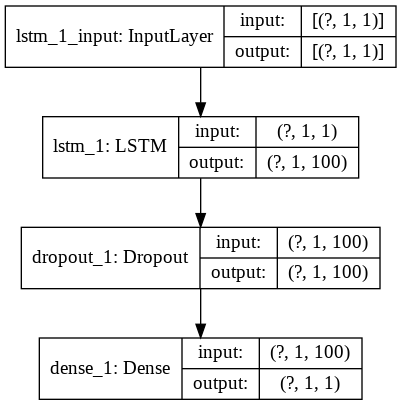

In [0]:
visualize (model1)

In [0]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('train vs. validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

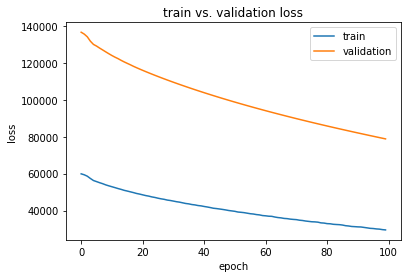

In [0]:
plot_loss(history)

In [0]:
def plot_Close(model, x_train, x_test):
  predict_train = model.predict(x_train)
  predict_train = predict_train.reshape(predict_train.shape[0], 1)
  
  predict_test = model.predict(x_test)
  predict_test = predict_test.reshape(predict_test.shape[0], 1)


  plt.figure(figsize = (12,5))
  plt.plot(y_train, label = 'real')
  plt.plot(predict_train, label = 'predicted')
  plt.title('real vs. predicted Close (train set)')
  plt.xlabel('Time')
  plt.ylabel('Close')
  plt.legend()

  plt.subplots(1,1, figsize = (12, 5))
  plt.plot(y_test, label = 'real')
  plt.plot(predict_test, label = 'predicted')
  plt.title('real vs. predicted Close (test set)')
  plt.xlabel('Time')
  plt.ylabel('Close')
  plt.legend()
  plt.show()

  return predict_train, predict_test

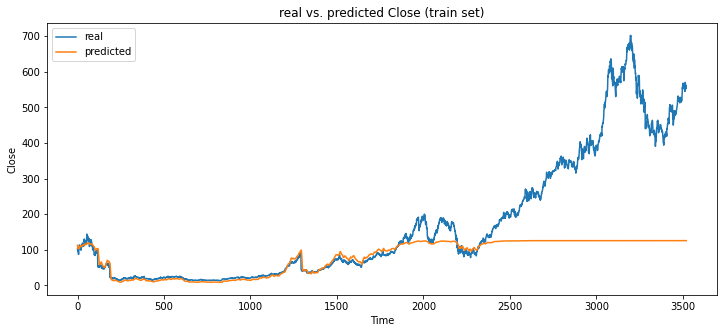

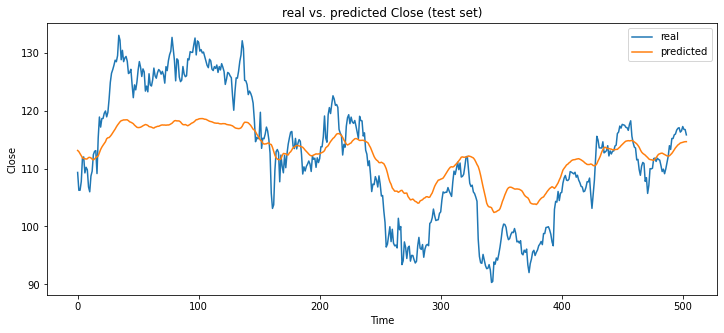

In [0]:
predict_Close_train1, predict_Close_test1  = plot_Close(model1, x_train1, x_test1)

Model1 has several problems:
- 1) Validation loss is way higher than train loss, which indicates that Model1 may be **underfitting**. And the two losses failed to converge to a stable point at the end.
- 2) Predicted Close on the train set converges to a constant number after a while and predicted Close on the test set is off a lot, which means the **model might not be trained long enough**. 

**Next goals:**
  - solve underfitting issue
  - make the model learn longer and better

**Up next in fine-tuning**:
  - reduce `min_delta` and increase `epochs` --> train longer
  - increase batch size --> feed more examples at a time thus learn better
  - smaller learning rate --> learn better

## E. Fine Tuning

### reduce `min_delta` and increase `epochs`

- `units_filter` = [100], `min_delta` = 50, `batch_size` = 128, `epochs` = 1000

In [0]:
model1 = createModel (input_shape=(x_train1.shape[1], x_train1.shape[2]), units_filter=[100])
history = trainModel(model1, x_train1, y_train, x_valid1, y_valid, x_test1, y_test, min_delta = 50, batch_size = 128, epochs = 1000)

Epoch 1/1000
28/28 [==============================] - 0s 15ms/step - loss: 59478.6953 - val_loss: 135954.0625
Epoch 2/1000
28/28 [==============================] - 0s 4ms/step - loss: 58951.0312 - val_loss: 134978.4062
Epoch 3/1000
28/28 [==============================] - 0s 4ms/step - loss: 58158.3516 - val_loss: 133551.5156
Epoch 4/1000
28/28 [==============================] - 0s 4ms/step - loss: 57380.8594 - val_loss: 131878.1094
Epoch 5/1000
28/28 [==============================] - 0s 4ms/step - loss: 56455.6055 - val_loss: 130582.3828
Epoch 6/1000
28/28 [==============================] - 0s 4ms/step - loss: 55769.4805 - val_loss: 129210.9531
Epoch 7/1000
28/28 [==============================] - 0s 5ms/step - loss: 55225.3594 - val_loss: 128378.1172
Epoch 8/1000
28/28 [==============================] - 0s 4ms/step - loss: 54714.2461 - val_loss: 127498.3438
Epoch 9/1000
28/28 [==============================] - 0s 4ms/step - loss: 54239.7031 - val_loss: 126647.6094
Epoch 10/1000
28/2

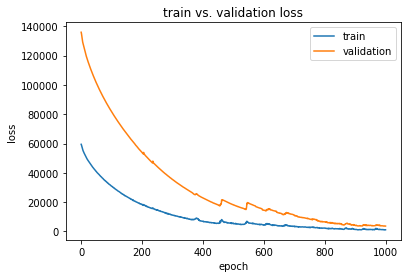

In [0]:
plot_loss(history)

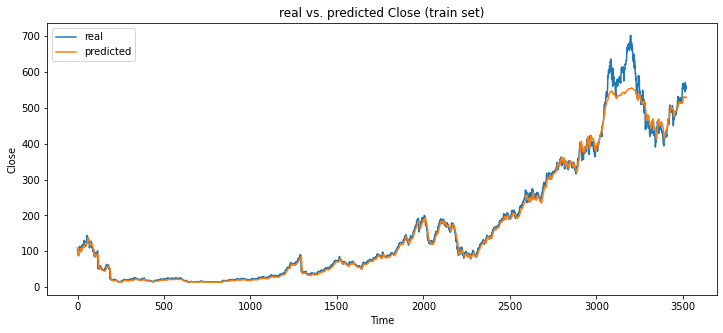

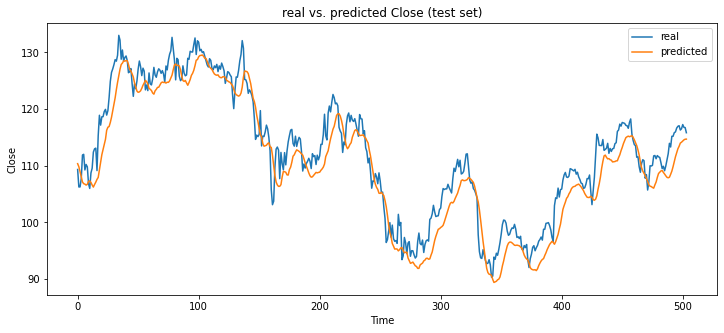

In [0]:
predict_Close_train1, predict_Close_test1  = plot_Close(model1, x_train1, x_test1)

- Performance of predicted Close on both train and test sets improved a lot.
- Let's see how the real vs. predicted Return looks like.

In [0]:
real_Return_train = AAPL_train['Return']
real_Return_test = AAPL_test['Return']

def plot_Return (predict_Close_train, predict_Close_test):
  predict_Return_train = pd.DataFrame(predict_Close_train).pct_change()
  predict_Return_test= pd.DataFrame(predict_Close_test).pct_change()
  
  plt.figure(figsize = (12,5))
  plt.plot(real_Return_train, label = 'real')
  plt.plot(predict_Return_train, label = 'predicted')
  plt.title('real vs. predicted Return (train set)')
  plt.xticks([])
  plt.xlabel('Time')
  plt.ylabel('Return')
  plt.legend()


  plt.subplots(1,1, figsize = (12, 5))
  plt.plot(real_Return_test, label = 'real')
  plt.plot(predict_Return_test, label = 'predicted')
  plt.title('real vs. predicted Return (test set)')
  plt.xticks([])
  plt.xlabel('Time')
  plt.ylabel('Return')
  plt.legend()
  plt.show()

  return predict_Return_train, predict_Return_test

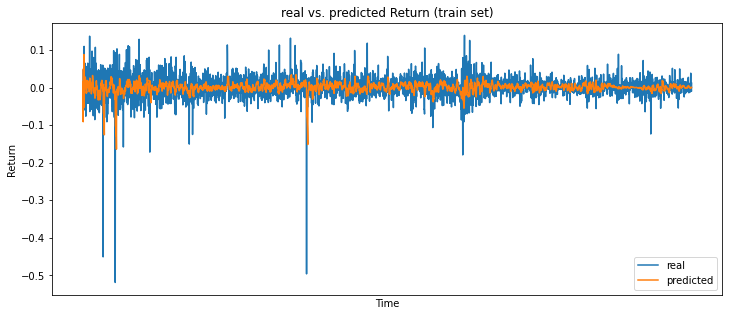

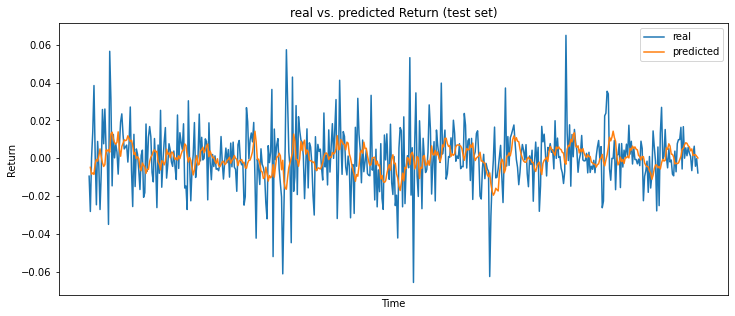

In [0]:
predict_Return_train1, predict_Return_test1 = plot_Return (predict_Close_train1, predict_Close_test1)

**Loss**:
- The underfitting issue of Model1 is solved. However, there's some **fluctuation** in losses at the end. 

**Close**:
- Predicted Close on the train set now has a similar trend to real Close, except on the last period. Predicted Close on the test set also has a good trend, but it's lower than the real Close. 

**Return**:
- Although predicted Return approximately follows the trend of real Return, it has a smaller scale than real Return and fails to predict extreme values.

**Why?**
- As I only use one feature AAPL's `MA7` in this model, there might not be enough info for the model to learn well--> **more feature engineering in Model2**

**Next goal**: 
- solve loss fluctuation by increasing batch_size


### increase `batch_size`

- `units_filter` = [100], `min_delta` = 50, `batch_size` = 512, `epochs` = 1000

In [0]:
model1 = createModel (input_shape=(x_train1.shape[1], x_train1.shape[2]), units_filter=[100])
history = trainModel(model1, x_train1, y_train, x_valid1, y_valid, x_test1, y_test, min_delta = 50, batch_size = 512, epochs = 1000)

Epoch 1/1000
7/7 [==============================] - 0s 50ms/step - loss: 60344.6758 - val_loss: 137716.3125
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 60147.0703 - val_loss: 137371.3281
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 59994.4453 - val_loss: 137105.2656
Epoch 4/1000
7/7 [==============================] - 0s 7ms/step - loss: 59867.7500 - val_loss: 136881.6875
Epoch 5/1000
7/7 [==============================] - 0s 7ms/step - loss: 59719.7344 - val_loss: 136627.8750
Epoch 6/1000
7/7 [==============================] - 0s 7ms/step - loss: 59566.6914 - val_loss: 136333.2188
Epoch 7/1000
7/7 [==============================] - 0s 7ms/step - loss: 59416.8828 - val_loss: 136071.5156
Epoch 8/1000
7/7 [==============================] - 0s 8ms/step - loss: 59290.8203 - val_loss: 135895.4219
Epoch 9/1000
7/7 [==============================] - 0s 7ms/step - loss: 59173.0430 - val_loss: 135681.9688
Epoch 10/1000
7/7 [=================

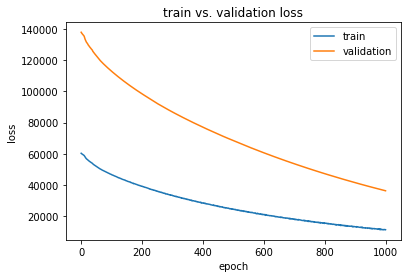

In [0]:
plot_loss(history)

- 1000 epochs are not enough for 512 batch_size. The model has not learned enough yet. There's even no convergence of the two losses. And val_loss is much larger now.

- Let's increase epochs to 2000

- `units_filter` = [100], `min_delta` = 50, `batch_size` = 512, `epochs` = 2000

Epoch 1/2000
7/7 [==============================] - 0s 50ms/step - loss: 60093.8828 - val_loss: 137295.9062
Epoch 2/2000
7/7 [==============================] - 0s 7ms/step - loss: 59990.6875 - val_loss: 137153.7188
Epoch 3/2000
7/7 [==============================] - 0s 8ms/step - loss: 59833.0195 - val_loss: 136835.4375
Epoch 4/2000
7/7 [==============================] - 0s 9ms/step - loss: 59693.5742 - val_loss: 136595.1250
Epoch 5/2000
7/7 [==============================] - 0s 7ms/step - loss: 59550.2734 - val_loss: 136327.7812
Epoch 6/2000
7/7 [==============================] - 0s 7ms/step - loss: 59393.5508 - val_loss: 136056.9844
Epoch 7/2000
7/7 [==============================] - 0s 7ms/step - loss: 59239.4648 - val_loss: 135765.8125
Epoch 8/2000
7/7 [==============================] - 0s 7ms/step - loss: 59080.2656 - val_loss: 135480.5781
Epoch 9/2000
7/7 [==============================] - 0s 7ms/step - loss: 58859.1680 - val_loss: 135037.5625
Epoch 10/2000
7/7 [=================

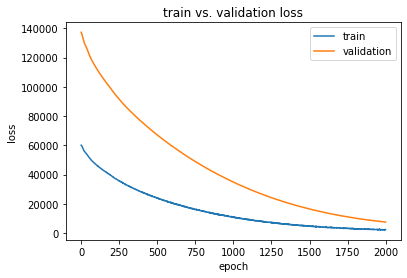

In [0]:
model1 = createModel (input_shape=(x_train1.shape[1], x_train1.shape[2]), units_filter=[100])
history = trainModel(model1, x_train1, y_train, x_valid1, y_valid, x_test1, y_test, min_delta = 50, batch_size = 512, epochs = 2000)
plot_loss(history)

- With 2000 epochs, Model1 now gives a legit loss plot, no underfitting and fluctuation.
- Let's see how predicted Close and predicted Return look like.

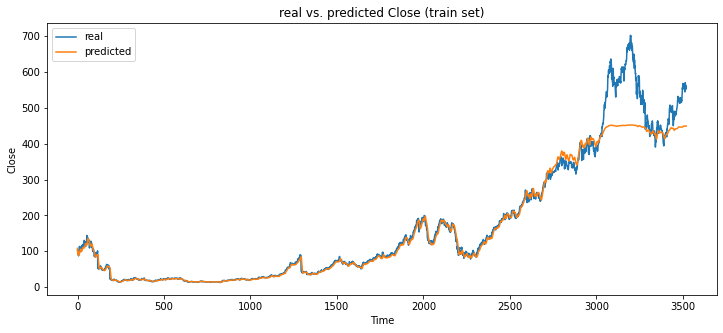

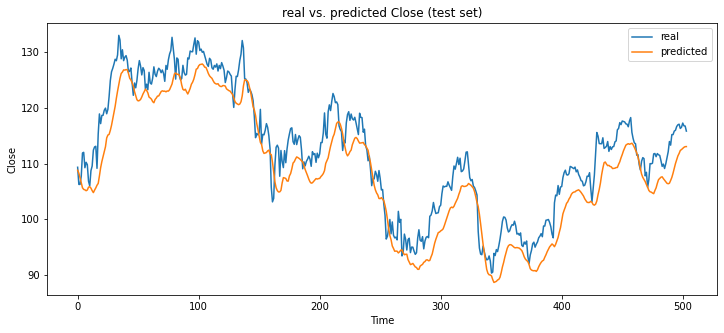

In [0]:
predict_Close_train1, predict_Close_test1  = plot_Close(model1, x_train1, x_test1)

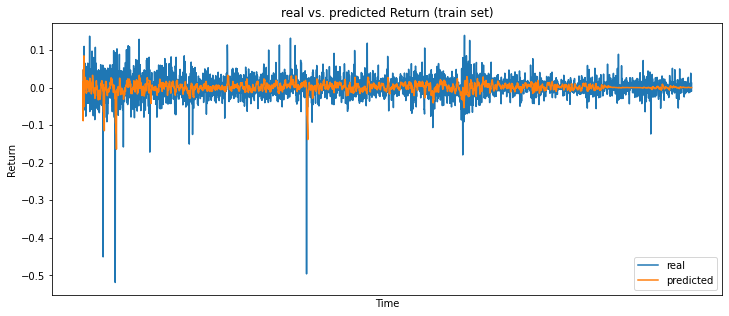

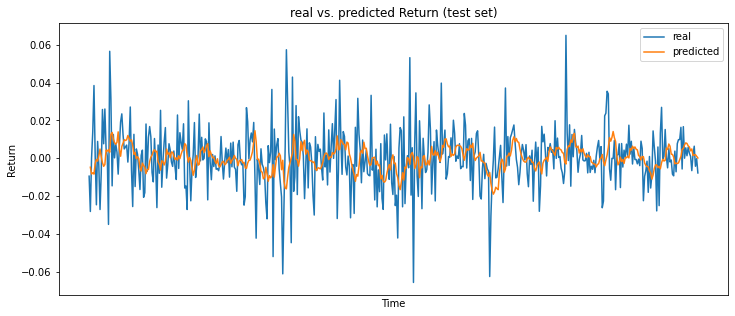

In [0]:
predict_Return_train1, predict_Return_test1 = plot_Return (predict_Close_train1, predict_Close_test1)

- Improvement on predicted Close and predicted Return is not very obvious. Maybe using only one feature is a problem.
- **Next goal: more features to introduce more info to the model**

### smaller learning rate
I also want to see if smaller learning rate will help Model1 to learn better
- change adam's learning rate from default 0.01 to 0.0008
- and accordingly increase epochs to let the model learn longer  

In [0]:
def trainModel_lr(model, x_train, y_train, x_valid, y_valid, x_test, y_test, min_delta, batch_size, epochs):
  
  # create Early Stopping call backs: 
  es_callback = EarlyStopping(monitor='val_loss' , min_delta = min_delta, patience=100,
                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  # compile (specify optimizer, loss function, metrics)
  opt = keras.optimizers.Adam(learning_rate=0.0008)
  model.compile(loss='mean_squared_error', optimizer = opt)
  
  # fit on training (and validation) data sets
  history = model.fit(x_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks= [ es_callback ],
            validation_data=(x_valid, y_valid),
            shuffle = False
            )
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test MSE loss:', score)

  return history

- `units_filter` = [100], `min_delta` = 50, `batch_size` = 512, `epochs` = 4000, `learning_rate` = 0.0008

Streaming output truncated to the last 5000 lines.
Epoch 1104/4000
7/7 [==============================] - 0s 7ms/step - loss: 13560.1436 - val_loss: 41639.7969
Epoch 1105/4000
7/7 [==============================] - 0s 7ms/step - loss: 13461.4912 - val_loss: 41594.4141
Epoch 1106/4000
7/7 [==============================] - 0s 7ms/step - loss: 13521.3232 - val_loss: 41548.7656
Epoch 1107/4000
7/7 [==============================] - 0s 7ms/step - loss: 13441.3936 - val_loss: 41506.7305
Epoch 1108/4000
7/7 [==============================] - 0s 6ms/step - loss: 13340.6865 - val_loss: 41459.5000
Epoch 1109/4000
7/7 [==============================] - 0s 7ms/step - loss: 13291.0518 - val_loss: 41413.1758
Epoch 1110/4000
7/7 [==============================] - 0s 6ms/step - loss: 13284.1865 - val_loss: 41367.1523
Epoch 1111/4000
7/7 [==============================] - 0s 7ms/step - loss: 13287.9883 - val_loss: 41328.9375
Epoch 1112/4000
7/7 [==============================] - 0s 7ms/step - loss: 13

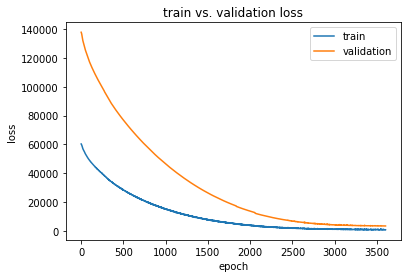

In [0]:
model1 = createModel (input_shape=(x_train1.shape[1], x_train1.shape[2]), units_filter = [100])
history = trainModel_lr(model1, x_train1, y_train, x_valid1, y_valid, x_test1, y_test, min_delta = 50, batch_size = 512, epochs = 4000)
plot_loss(history)

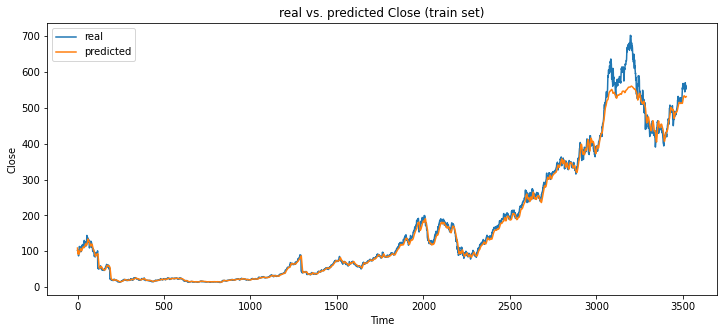

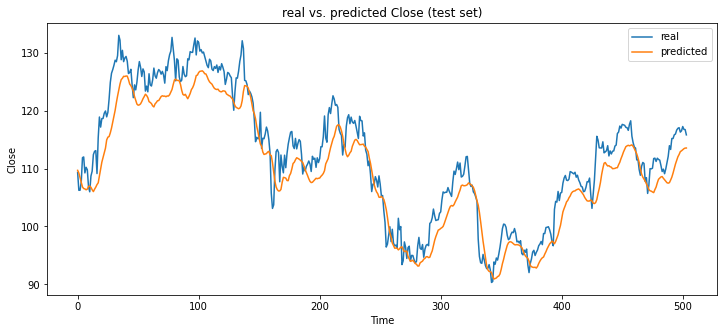

In [0]:
predict_Close_train1, predict_Close_test1  = plot_Close(model1, x_train1, x_test1)

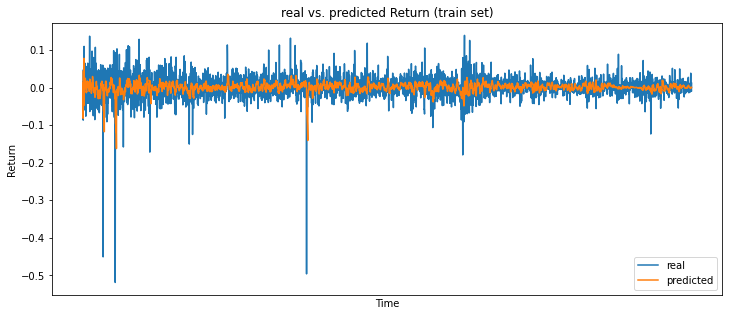

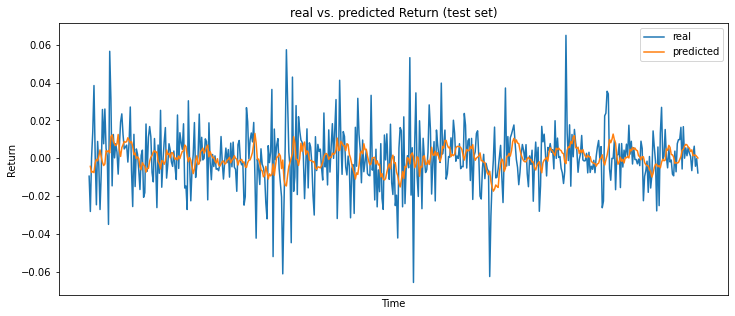

In [0]:
predict_Return_train1, predict_Return_test1 = plot_Return (predict_Close_train1, predict_Close_test1)

- Smaller learning rate helps to improve the predicted Close and Return.
-  So I will use min_delta = 50, batch_size = 512, epochs = 4000, learning_rate = 0.0008 in the future models

# Model2 (add AAPL Volume)

## create x, y

- In this model, I will use AAPL's `MA7` and `Volume` 
- As y_train is one day later than x_train2, there's no look_ahead issue

In [0]:
x_train2 = pd.concat([AAPL_train['MA7'], AAPL_train['Volume'] ], axis = 1)
x_valid2 = pd.concat([AAPL_valid['MA7'], AAPL_valid['Volume'] ], axis = 1)
x_test2 = pd.concat([AAPL_test['MA7'], AAPL_test['Volume'] ], axis = 1)

In [0]:
x_train2

MA7       Volume
Dt                                 
2000-01-03         NaN  133949200.0
2000-01-04         NaN  128094400.0
2000-01-05         NaN  194580400.0
2000-01-06         NaN  191993200.0
2000-01-07         NaN  115183600.0
...                ...          ...
2013-12-24  554.465714   41888700.0
2013-12-26  556.357143   51002000.0
2013-12-27  557.271429   56471100.0
2013-12-30  558.000000   63407400.0
2013-12-31  558.535714   55771100.0

[3521 rows x 2 columns]

In [0]:
x_valid2

MA7       Volume
Dt                                 
2014-01-02  560.901429   58671200.0
2014-01-03  561.488571   98116900.0
2014-01-06  557.330000  103152700.0
2014-01-07  553.938571   79302300.0
2014-01-08  550.529714   64632400.0
...                ...          ...
2014-12-24  110.612857   14479600.0
2014-12-26  111.153571   33721000.0
2014-12-29  112.188571   27598900.0
2014-12-30  112.831429   29881500.0
2014-12-31  112.812857   41403400.0

[252 rows x 2 columns]

In [0]:
x_test2

MA7      Volume
Dt                                
2015-01-02  112.612857  53204600.0
2015-01-05  112.097143  64285500.0
2015-01-06  111.198571  65797100.0
2015-01-07  110.377143  40105900.0
2015-01-08  109.485714  59364500.0
...                ...         ...
2016-12-23  116.274286  14249500.0
2016-12-27  116.464286  18296900.0
2016-12-28  116.670000  20905900.0
2016-12-29  116.782857  15039500.0
2016-12-30  116.795714  30586300.0

[504 rows x 2 columns]

## C.1 Cleaning
- Only x_train2 has NaN
- fill NaN in MA7 with actual Close

In [0]:
for i in range(7):
  x_train2['MA7'][i] = AAPL_train['Close'][i]

In [0]:
x_train2

MA7       Volume
Dt                                 
2000-01-03  111.938000  133949200.0
2000-01-04  102.500000  128094400.0
2000-01-05  104.000000  194580400.0
2000-01-06   95.000000  191993200.0
2000-01-07   99.500000  115183600.0
...                ...          ...
2013-12-24  554.465714   41888700.0
2013-12-26  556.357143   51002000.0
2013-12-27  557.271429   56471100.0
2013-12-30  558.000000   63407400.0
2013-12-31  558.535714   55771100.0

[3521 rows x 2 columns]

## C.3 Transformation

In [0]:
x_train2.shape, x_valid2.shape, x_test2.shape

((3521, 2), (252, 2), (504, 2))

In [0]:
x_train2, x_valid2, x_test2= reshape_3D(x_train2, x_valid2, x_test2)

In [0]:
x_train2.shape, x_valid2.shape, x_test2.shape

((3521, 1, 2), (252, 1, 2), (504, 1, 2))

## D.2 D.3 Fit & Validation on test set

In [0]:
model2 = createModel (input_shape=(x_train2.shape[1], x_train2.shape[2]), units_filter = [100])
history = trainModel_lr(model2, x_train2, y_train, x_valid2, y_valid, x_test2, y_test, min_delta = 50, batch_size = 512, epochs = 4000)
plot_loss(history)

Streaming output truncated to the last 5000 lines.
Epoch 1502/4000
7/7 [==============================] - 0s 6ms/step - loss: 37868.3906 - val_loss: 92280.2109
Epoch 1503/4000
7/7 [==============================] - 0s 8ms/step - loss: 37859.8203 - val_loss: 92261.6797
Epoch 1504/4000
7/7 [==============================] - 0s 6ms/step - loss: 37868.1562 - val_loss: 92243.1953
Epoch 1505/4000
7/7 [==============================] - 0s 7ms/step - loss: 37889.8438 - val_loss: 92224.8203
Epoch 1506/4000
7/7 [==============================] - 0s 7ms/step - loss: 37904.2695 - val_loss: 92206.4141
Epoch 1507/4000
7/7 [==============================] - 0s 7ms/step - loss: 37844.0625 - val_loss: 92188.0312
Epoch 1508/4000
7/7 [==============================] - 0s 6ms/step - loss: 38141.2461 - val_loss: 92169.6172
Epoch 1509/4000
7/7 [==============================] - 0s 6ms/step - loss: 38045.4062 - val_loss: 92151.3906
Epoch 1510/4000
7/7 [==============================] - 0s 8ms/step - loss: 37

## D.4 Error Analysis

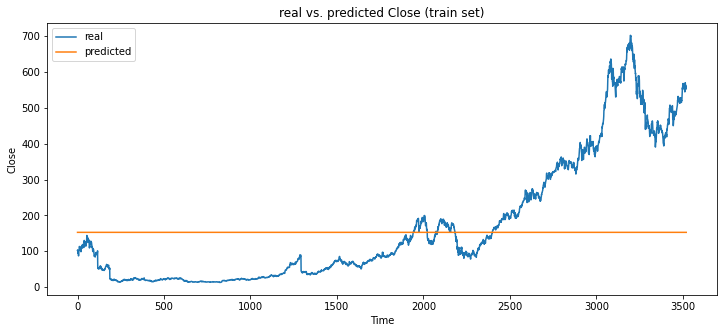

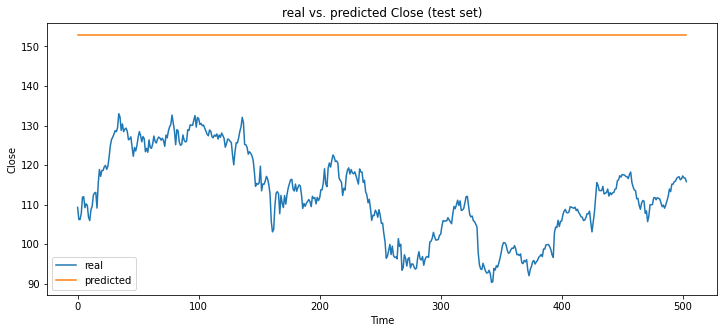

In [0]:
predict_Close_train2, predict_Close_test2  = plot_Close(model2, x_train2, x_test2)

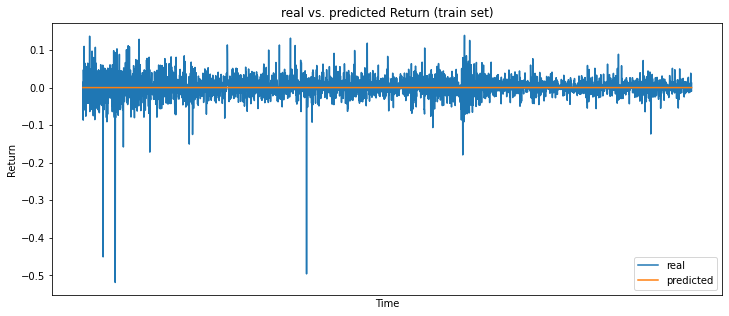

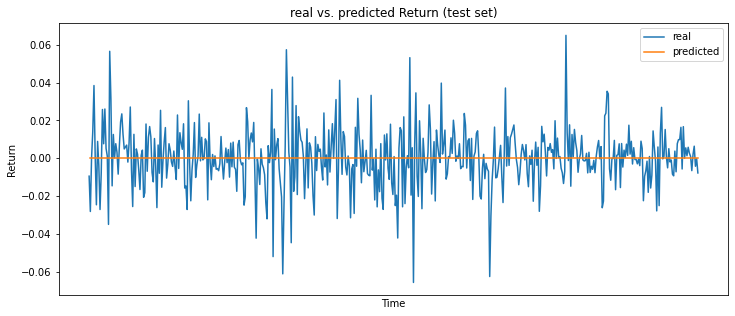

In [0]:
predict_Return_train2, predict_Return_test2 = plot_Return (predict_Close_train2, predict_Close_test2)

- Adding `Volume` causes the model to make very bad predictions. 
- Volume will be excluded from my feature engineering.


# Model3 (add other Close)
- Add Close of other most correlated tickers to introduce more information to the model

## B: EDA (check corr b/w returns)
check correlation with all other tickers: 
  - **ADBE, CRM, CSCO, FB, GOOG, IBM, INTC, MSFT, NVDA:** tech firms (software/hardware)
  - **MA:** Mastercard is the global payment network for Apple Card
  - **V:** Visa has a business called "Visa with Apple Pay". Visa is also a competitor to Mastercard.
  - **SPY:** SPY is designed to track the S&P 500 stock market index, which includes AAPL.
  - **XLK:** Technology Select Sector SPDR Fund (same sector as AAPL)
  - **XLY:** Consumer Discretionary SPDR (non-essential but purchased if consumers have sufficient incomes). Apple's products can be considered as consumer discretionary.
  - **XLB (Materials), XLE (Energy), XLF (Financial), XLI (Industrial), XLP (Consumer Staples), XLRE (Real Estate), XLU (Utilities SPDR), XLV (Health Care):** subsectors of S&P, so (indirectly) correlated with AAPL


1. Create a dataframe representing returns for all tickers
  - Note: `returns` covers dates from 2000-01-03 to 2016-12-30, need to split later

In [0]:
returns_col = []
for tick in tickers:
  returns_col.append (tick + ' return')

In [0]:
print(returns_col)

['AAPL return', 'ACN return', 'ADBE return', 'CRM return', 'CSCO return', 'FB return', 'GOOG return', 'IBM return', 'INTC return', 'MA return', 'MSFT return', 'NVDA return', 'SPY return', 'V return', 'XLB return', 'XLE return', 'XLF return', 'XLI return', 'XLK return', 'XLP return', 'XLRE return', 'XLU return', 'XLV return', 'XLY return']


In [0]:
returns = pd.DataFrame(columns=returns_col)

for col, df in zip(returns_col, dfs):
  returns[col] = df['Return']

returns.head()

AAPL return  ACN return  ...  XLV return  XLY return
Dt                                   ...                        
2000-01-03          NaN         NaN  ...         NaN         NaN
2000-01-04    -0.084315         NaN  ...   -0.022709   -0.030075
2000-01-05     0.014634         NaN  ...   -0.008950   -0.012321
2000-01-06    -0.086538         NaN  ...    0.003203    0.011400
2000-01-07     0.047368         NaN  ...    0.012195    0.047108

[5 rows x 24 columns]

In [0]:
returns.shape

(4277, 24)

2. Plot the correlation between AAPL and other tickers
  - Note: only plot the time range of the training set, i.e. `returns.loc['2000-01-03':'2013-12-31', :]` We don't want to accidentally look into the future

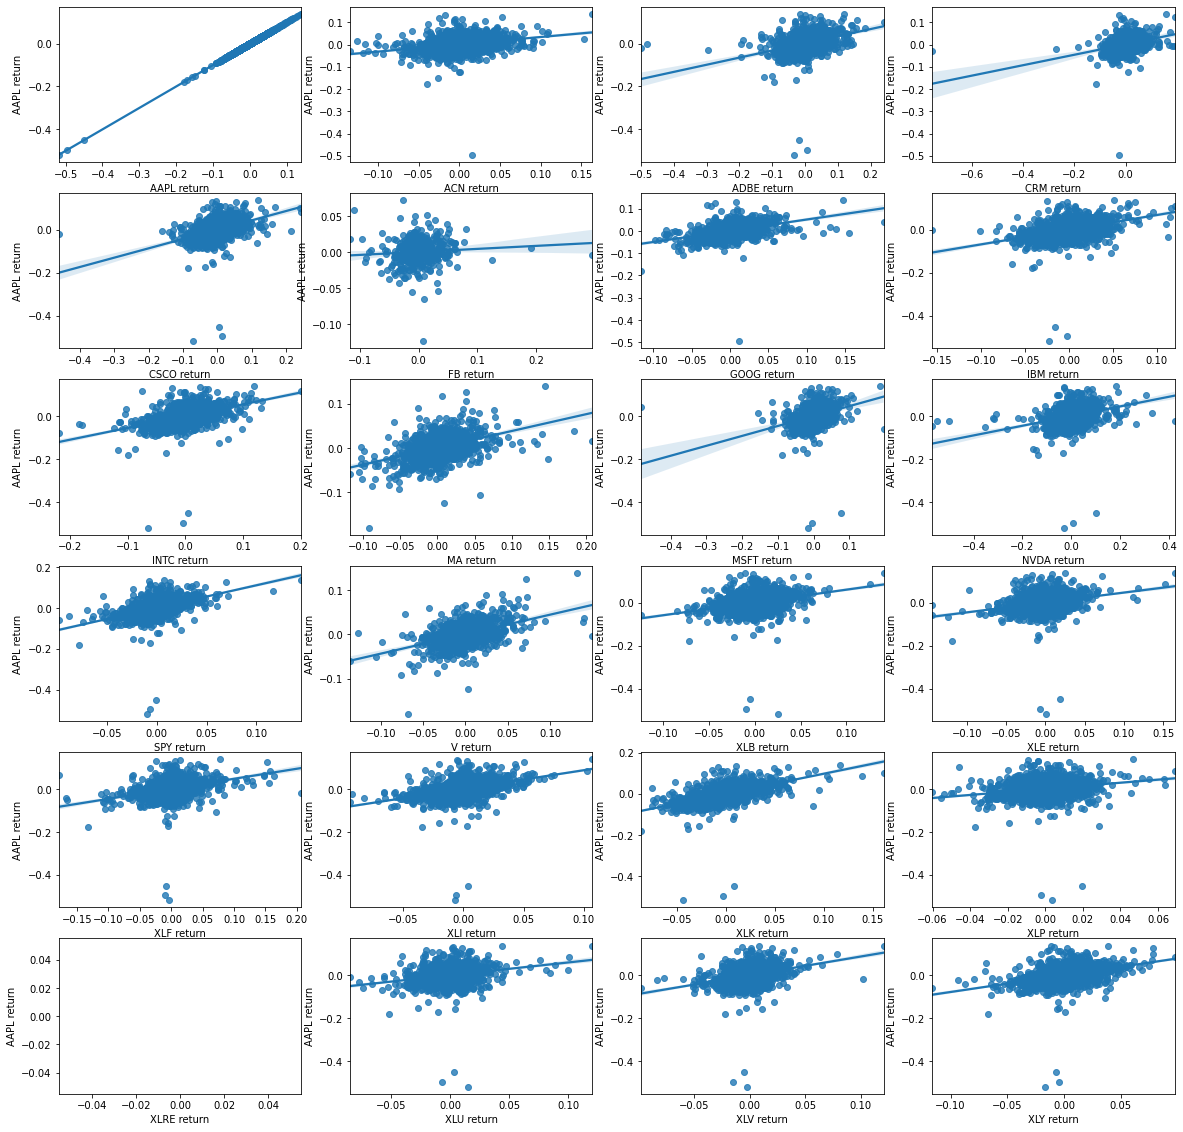

In [0]:
fig, axes = plt.subplots(6, 4, figsize = (20, 20))

for x, ax in zip(returns_col,  axes.flatten()):
  sns.regplot(data = returns.loc['2000-01-03':'2013-12-31', :], y='AAPL return', x=x, ax=ax)

3. Interpret plots and correlation coefficients

In [0]:
corr = returns.loc['2000-01-03':'2013-12-31', :].corr()
corr['AAPL return'].nlargest(25)

AAPL return    1.000000
XLK return     0.557730
SPY return     0.473646
INTC return    0.457835
V return       0.454336
MA return      0.425141
GOOG return    0.419631
XLI return     0.407431
CSCO return    0.404571
IBM return     0.387121
XLY return     0.386872
ADBE return    0.355703
XLV return     0.335254
MSFT return    0.334404
NVDA return    0.333606
XLF return     0.327894
XLB return     0.321983
CRM return     0.317737
XLE return     0.274788
ACN return     0.270208
XLU return     0.242132
XLP return     0.227810
FB return      0.078665
Name: AAPL return, dtype: float64

- Strong correlation:  coefficient between 0.50 and 1
  - XLK
  - **I will include XLK in model3** 
- Medium correlation: between 0.30 and 0.49
  - SPY > INTC > V > MA > GOOG > XLI > CSCO > IBM > XLY > ADBE > XLV > MSFT > NVDA > XLF > XLB > CRM 
    - **I choose to add SPY, INTC, XLI, CSCO in model3.** Their returns have higher than 40% correlations with AAPL return. 
    - IBM, XLY, ADBE, XLV, MSFT, NVDA, XLF, XLB, CRM are excluded because their correlations are not strong enough. They will create noise and give a not very accurate return if included in the model.
    
    - V, MA, GOOG and CRM are excluded because they have severe missing data problem
- Small correlation: below 0.29
  - XLE > ACN > XLU > XLP > FB
  - They will be excluded because the correlation is low
- Note: XLRE has no data until 2015-10-08, so `returns['XLRE return']` all NaN. Severe missing data issues --> exclude from feature engineering


## create x, y
- In Model3, I will use AAPL's `MA7`, `XLK Close`, `SPY Close`, `INTC Close`, `XLI Close`, `CSCO Close`.
- As `y_train` is one day later than `x_train3`, there's no look_ahead issue

In [0]:
tickers_to_use = ['XLK', 'SPY', 'INTC', 'XLI', 'CSCO'] 
dfs_to_use = [XLK, SPY, INTC, XLI, CSCO] 
Close_col = []
for tick in tickers_to_use:
  Close_col.append (tick + ' Close')
print(Close_col)

['XLK Close', 'SPY Close', 'INTC Close', 'XLI Close', 'CSCO Close']


In [0]:
Closes = pd.DataFrame(columns=Close_col)

for col, df in zip(Close_col, dfs_to_use):
  Closes[col] = df['Close']

Closes.head()

XLK Close  SPY Close  INTC Close  XLI Close  CSCO Close
Dt                                                                 
2000-01-03     55.438    145.438      43.500     28.844     108.063
2000-01-04     52.625    139.750      41.469     28.047     102.000
2000-01-05     51.844    140.000      41.813     27.922     101.688
2000-01-06     50.125    137.750      39.375     28.297     100.000
2000-01-07     51.000    145.750      41.000     29.375     105.875

In [0]:
x_train3 = pd.concat([AAPL_train['MA7'], Closes.loc['2000-01-03':'2013-12-31', :]], axis = 1)
x_valid3 = pd.concat([AAPL_valid['MA7'], Closes.loc['2014-01-02':'2014-12-31', :]], axis = 1) 
x_test3 = pd.concat([AAPL_test['MA7'], Closes.loc['2015-01-02':'2016-12-30', :]], axis = 1)


In [0]:
x_train3

MA7  XLK Close  SPY Close  INTC Close  XLI Close  CSCO Close
Dt                                                                             
2000-01-03         NaN     55.438    145.438      43.500     28.844     108.063
2000-01-04         NaN     52.625    139.750      41.469     28.047     102.000
2000-01-05         NaN     51.844    140.000      41.813     27.922     101.688
2000-01-06         NaN     50.125    137.750      39.375     28.297     100.000
2000-01-07         NaN     51.000    145.750      41.000     29.375     105.875
...                ...        ...        ...         ...        ...         ...
2013-12-24  554.465714     35.520    182.930      25.430     51.700      21.690
2013-12-26  556.357143     35.610    183.855      25.700     52.060      21.800
2013-12-27  557.271429     35.580    183.845      25.600     52.000      22.020
2013-12-30  558.000000     35.510    183.820      25.850     51.950      22.250
2013-12-31  558.535714     35.740    184.690      25.960     52.260      22.430

[3521 rows x 6 columns]

In [0]:
x_valid3

MA7  XLK Close  SPY Close  INTC Close  XLI Close  CSCO Close
Dt                                                                             
2014-01-02  560.901429      35.39    182.920       25.79      51.53      22.000
2014-01-03  561.488571      35.22    182.885       25.78      51.67      21.980
2014-01-06  557.330000      35.16    182.360       25.46      51.37      22.010
2014-01-07  553.938571      35.48    183.480       25.59      51.69      22.310
2014-01-08  550.529714      35.48    183.520       25.43      51.60      22.293
...                ...        ...        ...         ...        ...         ...
2014-12-24  110.612857      42.14    207.770       37.44      57.40      28.300
2014-12-26  111.153571      42.32    208.440       37.55      57.40      28.350
2014-12-29  112.188571      42.11    208.720       37.18      57.49      28.460
2014-12-30  112.831429      41.81    207.600       36.76      57.15      28.360
2014-12-31  112.812857      41.35    205.540       36.29      56.58      27.815

[252 rows x 6 columns]

In [0]:
x_test3

MA7  XLK Close  SPY Close  INTC Close  XLI Close  CSCO Close
Dt                                                                             
2015-01-02  112.612857      41.27     205.43       36.36      56.51       27.61
2015-01-05  112.097143      40.64     201.72       35.95      55.19       27.06
2015-01-06  111.198571      40.15     199.82       35.28      54.51       27.05
2015-01-07  110.377143      40.49     202.31       36.02      54.92       27.30
2015-01-08  109.485714      41.38     205.90       36.69      56.02       27.51
...                ...        ...        ...         ...        ...         ...
2016-12-23  116.274286      48.97     225.71       36.97      62.99       30.53
2016-12-27  116.464286      49.17     226.27       37.07      63.12       30.68
2016-12-28  116.670000      48.73     224.40       36.63      62.46       30.42
2016-12-29  116.782857      48.74     224.35       36.66      62.44       30.46
2016-12-30  116.795714      48.36     223.53       36.27      62.22       30.22

[504 rows x 6 columns]

## C.1 Cleaning
- Only `x_train3` has NaN
- fill NaN in MA7 with actual Close

In [0]:
for i in range(7):
  x_train3['MA7'][i] = AAPL_train['Close'][i]

In [0]:
x_train3

MA7  XLK Close  SPY Close  INTC Close  XLI Close  CSCO Close
Dt                                                                             
2000-01-03  111.938000     55.438    145.438      43.500     28.844     108.063
2000-01-04  102.500000     52.625    139.750      41.469     28.047     102.000
2000-01-05  104.000000     51.844    140.000      41.813     27.922     101.688
2000-01-06   95.000000     50.125    137.750      39.375     28.297     100.000
2000-01-07   99.500000     51.000    145.750      41.000     29.375     105.875
...                ...        ...        ...         ...        ...         ...
2013-12-24  554.465714     35.520    182.930      25.430     51.700      21.690
2013-12-26  556.357143     35.610    183.855      25.700     52.060      21.800
2013-12-27  557.271429     35.580    183.845      25.600     52.000      22.020
2013-12-30  558.000000     35.510    183.820      25.850     51.950      22.250
2013-12-31  558.535714     35.740    184.690      25.960     52.260      22.430

[3521 rows x 6 columns]

## C.3 Transformation

In [0]:
x_train3.shape, x_valid3.shape, x_test3.shape

((3521, 6), (252, 6), (504, 6))

In [0]:
x_train3, x_valid3, x_test3 = reshape_3D(x_train3, x_valid3, x_test3)

In [0]:
x_train3.shape, x_valid3.shape, x_test3.shape

((3521, 1, 6), (252, 1, 6), (504, 1, 6))

## D.2 D.3 Fit & Validation on test set

Streaming output truncated to the last 5000 lines.
Epoch 1128/4000
7/7 [==============================] - 0s 8ms/step - loss: 15856.0820 - val_loss: 48312.3477
Epoch 1129/4000
7/7 [==============================] - 0s 6ms/step - loss: 15936.5342 - val_loss: 48337.6328
Epoch 1130/4000
7/7 [==============================] - 0s 7ms/step - loss: 15847.1680 - val_loss: 48181.3984
Epoch 1131/4000
7/7 [==============================] - 0s 7ms/step - loss: 15656.8906 - val_loss: 48315.9336
Epoch 1132/4000
7/7 [==============================] - 0s 7ms/step - loss: 16058.7959 - val_loss: 48066.5430
Epoch 1133/4000
7/7 [==============================] - 0s 7ms/step - loss: 15820.4082 - val_loss: 48201.1953
Epoch 1134/4000
7/7 [==============================] - 0s 7ms/step - loss: 15931.2881 - val_loss: 47966.5781
Epoch 1135/4000
7/7 [==============================] - 0s 7ms/step - loss: 15573.9619 - val_loss: 48137.4883
Epoch 1136/4000
7/7 [==============================] - 0s 7ms/step - loss: 15

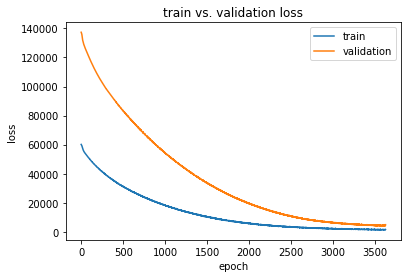

In [0]:
model3 = createModel (input_shape=(x_train3.shape[1], x_train3.shape[2]), units_filter=[100])
history = trainModel_lr(model3, x_train3, y_train, x_valid3, y_valid, x_test3, y_test, min_delta = 50, batch_size = 512, epochs = 4000)
plot_loss(history)

## D.4 Error Analysis

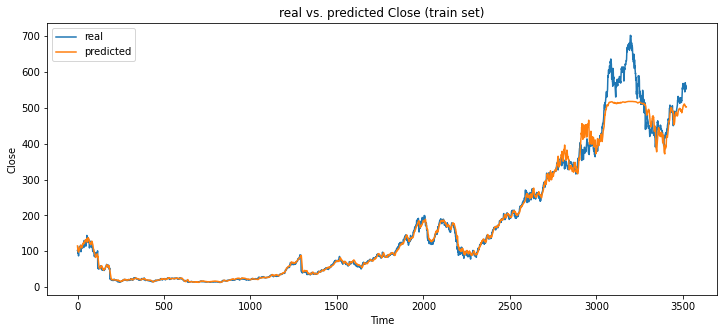

In [0]:
predict_Close_train3, predict_Close_test3  = plot_Close(model3, x_train3, x_test3)

In [0]:
predict_Return_train3, predict_Return_test3 = plot_Return (predict_Close_train3, predict_Close_test3)

- Predicted Close on the training set follows the real trend well, except on the last peak period. But predicted Close on the test set is less accurate compared to that in Model1 (where we only used MA7)
- Predicted Return on both training and test sets is better. Model3 is now able to predict extreme return values. 
- Thus, Model3 does learn better when given more information.

**Up next in fine-tuning**:
  - 14 features is a large number. I'm wondering if the one-layer LSTM is too weak to process so much info, thus gives a worse prediction on Close.
  - So, I will add more LSTM layers and see if that helps. 

## E Fine Tuning

In [0]:
model3 = createModel (input_shape=(x_train3.shape[1], x_train3.shape[2]), units_filter = [25, 25, 50])
history = trainModel_lr(model3, x_train3, y_train, x_valid3, y_valid, x_test3, y_test, min_delta = 50, batch_size = 512, epochs = 4000)
plot_loss(history)

Streaming output truncated to the last 5000 lines.
Epoch 1502/4000
7/7 [==============================] - 0s 11ms/step - loss: 20076.6777 - val_loss: 58461.8945
Epoch 1503/4000
7/7 [==============================] - 0s 9ms/step - loss: 20082.5078 - val_loss: 58425.5195
Epoch 1504/4000
7/7 [==============================] - 0s 10ms/step - loss: 19757.6230 - val_loss: 58381.0117
Epoch 1505/4000
7/7 [==============================] - 0s 9ms/step - loss: 20121.3691 - val_loss: 58380.2500
Epoch 1506/4000
7/7 [==============================] - 0s 10ms/step - loss: 20006.3203 - val_loss: 58569.0273
Epoch 1507/4000
7/7 [==============================] - 0s 10ms/step - loss: 19875.8945 - val_loss: 58424.8516
Epoch 1508/4000
7/7 [==============================] - 0s 9ms/step - loss: 20032.0586 - val_loss: 58290.2578
Epoch 1509/4000
7/7 [==============================] - 0s 9ms/step - loss: 19881.5625 - val_loss: 58344.1367
Epoch 1510/4000
7/7 [==============================] - 0s 10ms/step - los

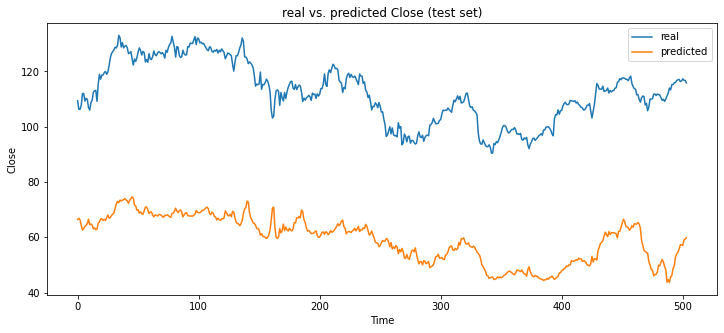

In [0]:
predict_Close_train3, predict_Close_test3  = plot_Close(model3, x_train3, x_test3)

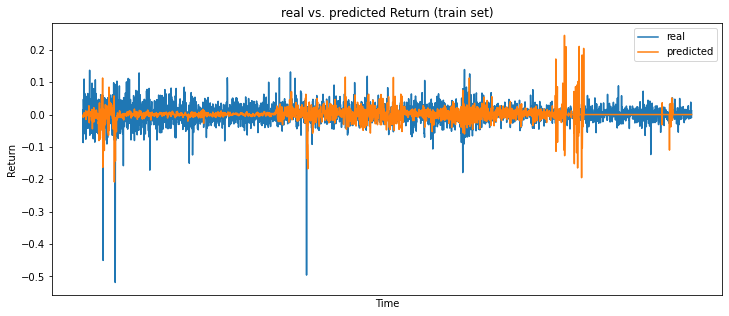

In [0]:
predict_Return_train3, predict_Return_test3 = plot_Return (predict_Close_train3, predict_Close_test3)

In [0]:
visualize(model3)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1, 25)             3200      
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 25)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1, 25)             5100      
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 25)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 50)             15200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1, 1)            

- Adding more LSTM layers does not improve the model. Instead too many parameters cause:
  - worse prediction of Close on both sets
  - worse prediction on Return on both sets
- Thus, I will stick with my initial one-layer LSTM model

# Model4 (add other Adj Close)
- I will add `Adj Close` of `tickers_to_use` to see if Adj Close helps improve model performance.
- I am a little suspicious, because Adj Close is on a different scale than Close and MA7 and I don't plan to do scaling.

## create x, y


In [0]:
AdjClose_col = []
for tick in tickers_to_use:
  AdjClose_col.append (tick + ' AdjClose')
print(AdjClose_col)

['XLK AdjClose', 'SPY AdjClose', 'INTC AdjClose', 'XLI AdjClose', 'CSCO AdjClose']


In [0]:
AdjCloses = pd.DataFrame(columns=AdjClose_col)

for col, df in zip(AdjClose_col, dfs_to_use):
  AdjCloses[col] = df['Adj Close']

AdjCloses.head()

XLK AdjClose  SPY AdjClose  ...  XLI AdjClose  CSCO AdjClose
Dt                                      ...                             
2000-01-03       43.6306      100.4705  ...       20.0644        42.1339
2000-01-04       41.4171       96.5415  ...       19.5101        39.7701
2000-01-05       40.8022       96.7142  ...       19.4232        39.6482
2000-01-06       39.4496       95.1599  ...       19.6840        38.9903
2000-01-07       40.1382      100.6864  ...       20.4340        41.2810

[5 rows x 5 columns]

In [0]:
x_train4 = pd.concat([AAPL_train['MA7'], Closes.loc['2000-01-03':'2013-12-31', :],
                      AdjCloses.loc['2000-01-03':'2013-12-31', :]], axis = 1)
x_valid4 = pd.concat([AAPL_valid['MA7'], Closes.loc['2014-01-02':'2014-12-31', :],
                      AdjCloses.loc['2014-01-02':'2014-12-31', :]], axis = 1) 
x_test4= pd.concat([AAPL_test['MA7'], Closes.loc['2015-01-02':'2016-12-30', :],
                     AdjCloses.loc['2015-01-02':'2016-12-30', :]], axis = 1)


In [0]:
x_train4.head(10)

MA7  XLK Close  ...  XLI AdjClose  CSCO AdjClose
Dt                                 ...                             
2000-01-03         NaN     55.438  ...       20.0644        42.1339
2000-01-04         NaN     52.625  ...       19.5101        39.7701
2000-01-05         NaN     51.844  ...       19.4232        39.6482
2000-01-06         NaN     50.125  ...       19.6840        38.9903
2000-01-07         NaN     51.000  ...       20.4340        41.2810
2000-01-10         NaN     52.938  ...       20.4340        42.8162
2000-01-11         NaN     51.438  ...       20.1731        41.5246
2000-01-12  100.491143     51.219  ...       19.9340        40.4768
2000-01-13   96.955429     51.688  ...       20.3144        41.4028
2000-01-14   96.134000     52.875  ...       20.1731        41.9389

[10 rows x 11 columns]

## C.1 Cleaning
- Only `x_train4` has NaN
- fill NaN in `MA7` with actual `Close`

In [0]:
for i in range(7):
  x_train4['MA7'][i] = AAPL_train['Close'][i]

In [0]:
x_train4.head(10)

MA7  XLK Close  ...  XLI AdjClose  CSCO AdjClose
Dt                                 ...                             
2000-01-03  111.938000     55.438  ...       20.0644        42.1339
2000-01-04  102.500000     52.625  ...       19.5101        39.7701
2000-01-05  104.000000     51.844  ...       19.4232        39.6482
2000-01-06   95.000000     50.125  ...       19.6840        38.9903
2000-01-07   99.500000     51.000  ...       20.4340        41.2810
2000-01-10   97.750000     52.938  ...       20.4340        42.8162
2000-01-11   92.750000     51.438  ...       20.1731        41.5246
2000-01-12  100.491143     51.219  ...       19.9340        40.4768
2000-01-13   96.955429     51.688  ...       20.3144        41.4028
2000-01-14   96.134000     52.875  ...       20.1731        41.9389

[10 rows x 11 columns]

## C.3 Transformation

In [0]:
x_train4.shape, x_valid4.shape, x_test4.shape

((3521, 11), (252, 11), (504, 11))

In [0]:
x_train4, x_valid4, x_test4 = reshape_3D(x_train4, x_valid4, x_test4)

In [0]:
x_train4.shape, x_valid4.shape, x_test4.shape

((3521, 1, 11), (252, 1, 11), (504, 1, 11))

## D.2 D.3: Fit & Validation on test set


Streaming output truncated to the last 5000 lines.
Epoch 1153/4000
7/7 [==============================] - 0s 7ms/step - loss: 15927.9512 - val_loss: 48657.8828
Epoch 1154/4000
7/7 [==============================] - 0s 7ms/step - loss: 15835.9951 - val_loss: 48534.3555
Epoch 1155/4000
7/7 [==============================] - 0s 7ms/step - loss: 15711.8066 - val_loss: 48492.4180
Epoch 1156/4000
7/7 [==============================] - 0s 7ms/step - loss: 15706.3584 - val_loss: 48477.8359
Epoch 1157/4000
7/7 [==============================] - 0s 7ms/step - loss: 15611.4531 - val_loss: 48314.1641
Epoch 1158/4000
7/7 [==============================] - 0s 7ms/step - loss: 15760.8203 - val_loss: 48445.0039
Epoch 1159/4000
7/7 [==============================] - 0s 7ms/step - loss: 15652.9277 - val_loss: 48277.4609
Epoch 1160/4000
7/7 [==============================] - 0s 7ms/step - loss: 15663.2412 - val_loss: 48236.0781
Epoch 1161/4000
7/7 [==============================] - 0s 8ms/step - loss: 15

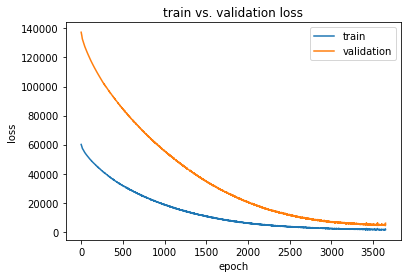

In [0]:
model4 = createModel (input_shape=(x_train4.shape[1], x_train4.shape[2]), units_filter = [100])
history = trainModel_lr(model4, x_train4, y_train, x_valid4, y_valid, x_test4, y_test, min_delta = 50, batch_size = 512, epochs = 4000)
plot_loss(history)

## D.4 Error Analysis

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 100)            44800     
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 1, 1)              101       
Total params: 44,901
Trainable params: 44,901
Non-trainable params: 0
_________________________________________________________________


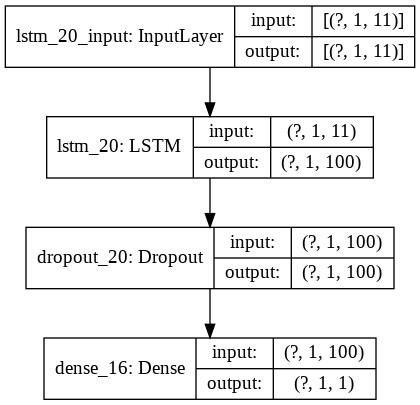

In [0]:
visualize(model4)

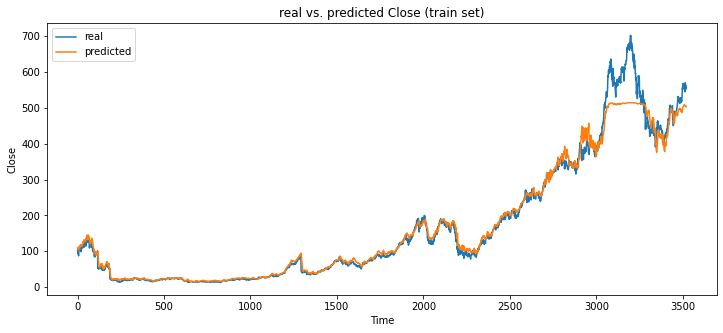

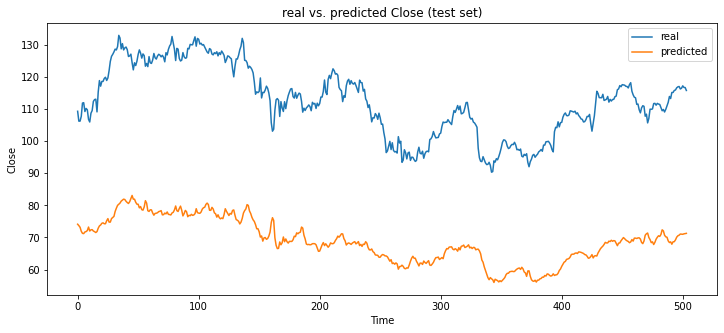

In [0]:
predict_Close_train4, predict_Close_test4  = plot_Close(model4, x_train4, x_test4)

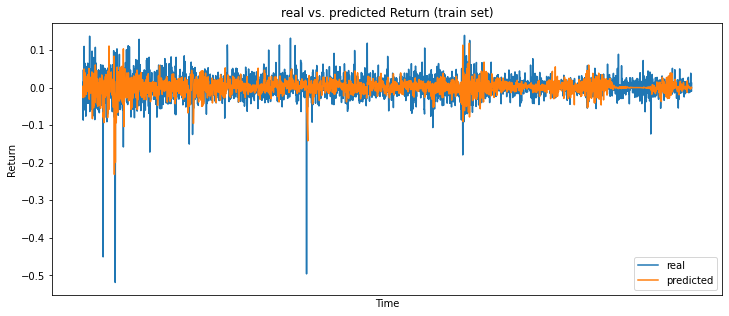

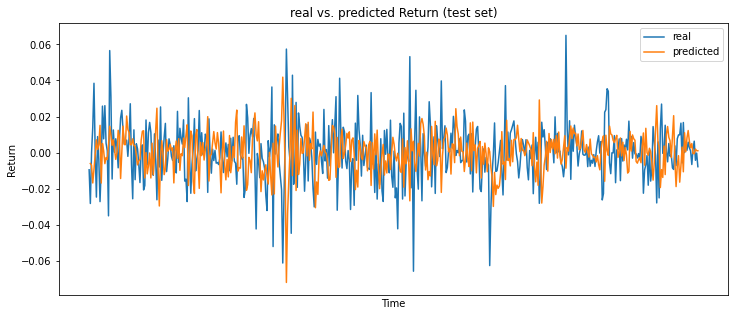

In [0]:
predict_Return_train4, predict_Return_test4 = plot_Return (predict_Close_train4, predict_Close_test4)

- Bigger Test MSE loss than Model3
- Predicted Close on train is similar to that in Model3, but prediction on test is worse.
- Predicted Return on train and test are both similar to that in Model3.

- **Summary: Adding Adj Close of other tickers is not very helpful. Model3 is the optimal model so far**.

# Model5 (add other MA7)

## create x, y


In [0]:
MA7_col = []
for tick in tickers_to_use:
  MA7_col.append (tick + ' MA7')
print(MA7_col)

['XLK MA7', 'SPY MA7', 'INTC MA7', 'XLI MA7', 'CSCO MA7']


In [0]:
MA7s = pd.DataFrame(columns=MA7_col)

for col, df in zip(MA7_col, dfs_to_use):
  MA7s[col] = df['MA7']

MA7s.head(10)

XLK MA7     SPY MA7   INTC MA7    XLI MA7    CSCO MA7
Dt                                                                 
2000-01-03        NaN         NaN        NaN        NaN         NaN
2000-01-04        NaN         NaN        NaN        NaN         NaN
2000-01-05        NaN         NaN        NaN        NaN         NaN
2000-01-06        NaN         NaN        NaN        NaN         NaN
2000-01-07        NaN         NaN        NaN        NaN         NaN
2000-01-10        NaN         NaN        NaN        NaN         NaN
2000-01-11        NaN         NaN        NaN        NaN         NaN
2000-01-12  52.201143  142.776857  42.125143  28.694286  104.848429
2000-01-13  51.598429  142.437571  42.428714  28.667429  104.241286
2000-01-14  51.464571  143.187571  43.009000  28.832571  104.839571

In [0]:
x_train5 = pd.concat([AAPL_train['MA7'], Closes.loc['2000-01-03':'2013-12-31', :],
                      MA7s.loc['2000-01-03':'2013-12-31', :]], axis = 1)

x_valid5 = pd.concat([AAPL_valid['MA7'], Closes.loc['2014-01-02':'2014-12-31', :],
                      MA7s.loc['2014-01-02':'2014-12-31', :]], axis = 1) 

x_test5 = pd.concat([AAPL_test['MA7'], Closes.loc['2015-01-02':'2016-12-30', :],
                     MA7s.loc['2015-01-02':'2016-12-30', :]], axis = 1)


In [0]:
x_train5.head(10)

MA7  XLK Close  SPY Close  ...   INTC MA7    XLI MA7    CSCO MA7
Dt                                            ...                                  
2000-01-03         NaN     55.438    145.438  ...        NaN        NaN         NaN
2000-01-04         NaN     52.625    139.750  ...        NaN        NaN         NaN
2000-01-05         NaN     51.844    140.000  ...        NaN        NaN         NaN
2000-01-06         NaN     50.125    137.750  ...        NaN        NaN         NaN
2000-01-07         NaN     51.000    145.750  ...        NaN        NaN         NaN
2000-01-10         NaN     52.938    146.250  ...        NaN        NaN         NaN
2000-01-11         NaN     51.438    144.500  ...        NaN        NaN         NaN
2000-01-12  100.491143     51.219    143.063  ...  42.125143  28.694286  104.848429
2000-01-13   96.955429     51.688    145.000  ...  42.428714  28.667429  104.241286
2000-01-14   96.134000     52.875    146.969  ...  43.009000  28.832571  104.839571

[10 rows x 11 columns]

## C.1 Cleaning
- Only `x_train5` has NaN
- fill NaN in `MA7` with actual `Close`

In [0]:
for i in range(7):
  x_train5['MA7'][i] = AAPL_train['Close'][i]

for col, df in zip(MA7_col, dfs_to_use):
  for i in range(7):
    x_train5[col][i] = df['Close'][i]

In [0]:
x_train5.head(10)

MA7  XLK Close  SPY Close  ...   INTC MA7    XLI MA7    CSCO MA7
Dt                                            ...                                  
2000-01-03  111.938000     55.438    145.438  ...  43.500000  28.844000  108.063000
2000-01-04  102.500000     52.625    139.750  ...  41.469000  28.047000  102.000000
2000-01-05  104.000000     51.844    140.000  ...  41.813000  27.922000  101.688000
2000-01-06   95.000000     50.125    137.750  ...  39.375000  28.297000  100.000000
2000-01-07   99.500000     51.000    145.750  ...  41.000000  29.375000  105.875000
2000-01-10   97.750000     52.938    146.250  ...  42.875000  29.375000  109.813000
2000-01-11   92.750000     51.438    144.500  ...  44.844000  29.000000  106.500000
2000-01-12  100.491143     51.219    143.063  ...  42.125143  28.694286  104.848429
2000-01-13   96.955429     51.688    145.000  ...  42.428714  28.667429  104.241286
2000-01-14   96.134000     52.875    146.969  ...  43.009000  28.832571  104.839571

[10 rows x 11 columns]

## C.3 Transformation

In [0]:
x_train5.shape, x_valid5.shape, x_test5.shape

((3521, 11), (252, 11), (504, 11))

In [0]:
x_train5, x_valid5, x_test5 = reshape_3D(x_train5, x_valid5, x_test5)

In [0]:
x_train5.shape, x_valid5.shape, x_test5.shape

((3521, 1, 11), (252, 1, 11), (504, 1, 11))

## D.2 D.3: Fit & Validation on test set


In [0]:
model5 = createModel (input_shape=(x_train5.shape[1], x_train5.shape[2]), units_filter = [100])
history = trainModel_lr(model5, x_train5, y_train, x_valid5, y_valid, x_test5, y_test, min_delta = 50, batch_size = 512, epochs = 4000)
plot_loss(history)

Streaming output truncated to the last 5000 lines.
Epoch 905/4000
7/7 [==============================] - 0s 7ms/step - loss: 19700.0879 - val_loss: 58511.5625
Epoch 906/4000
7/7 [==============================] - 0s 8ms/step - loss: 19954.6836 - val_loss: 58460.6641
Epoch 907/4000
7/7 [==============================] - 0s 7ms/step - loss: 19715.9082 - val_loss: 58407.3125
Epoch 908/4000
7/7 [==============================] - 0s 7ms/step - loss: 19666.8359 - val_loss: 58369.2969
Epoch 909/4000
7/7 [==============================] - 0s 8ms/step - loss: 19896.3906 - val_loss: 58228.2227
Epoch 910/4000
7/7 [==============================] - 0s 8ms/step - loss: 19654.1777 - val_loss: 58296.9844
Epoch 911/4000
7/7 [==============================] - 0s 7ms/step - loss: 19731.0215 - val_loss: 58176.1055
Epoch 912/4000
7/7 [==============================] - 0s 7ms/step - loss: 19832.8887 - val_loss: 58120.1875
Epoch 913/4000
7/7 [==============================] - 0s 7ms/step - loss: 19699.8730 

## D.4 Error Analysis

In [0]:
predict_Close_train5, predict_Close_test5 = plot_Close(model5, x_train5, x_test5)

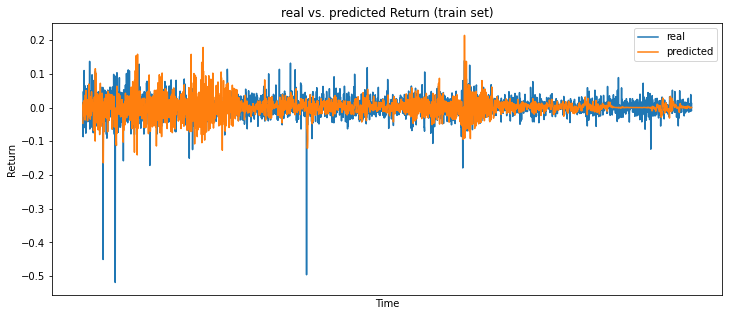

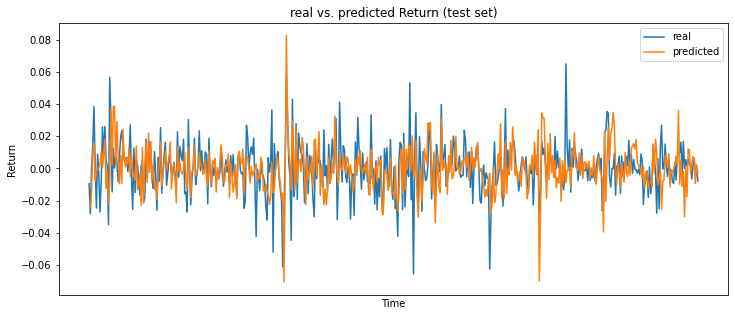

In [0]:
predict_Return_train5, predict_Return_test5 = plot_Return (predict_Close_train5, predict_Close_test5)

- Test MSE loss is just a little bit lower than that of Model4, still much higher than Model3
- Predicted Close on both train and test is worse than that in Model3.
- Predicted Return on train and test are both similar to that in Model3, not very improved.

**Summary: Adding MA7 of other tickers is not very helpful. Model3 is the optimal model so far.**

# Model6 (add AAPL Close)

## create x, y
- In Model6, I will add AAPL's `Close`


In [0]:
x_train6 = pd.concat([AAPL_train['MA7'], AAPL_train['Close'], Closes.loc['2000-01-03':'2013-12-31', :]], axis = 1)

x_valid6 = pd.concat([AAPL_valid['MA7'], AAPL_valid['Close'], Closes.loc['2014-01-02':'2014-12-31', :]], axis = 1) 

x_test6 = pd.concat([AAPL_test['MA7'], AAPL_test['Close'], Closes.loc['2015-01-02':'2016-12-30', :]], axis = 1)


In [0]:
x_train6.head(10)

MA7    Close  XLK Close  ...  INTC Close  XLI Close  CSCO Close
Dt                                          ...                                   
2000-01-03         NaN  111.938     55.438  ...      43.500     28.844     108.063
2000-01-04         NaN  102.500     52.625  ...      41.469     28.047     102.000
2000-01-05         NaN  104.000     51.844  ...      41.813     27.922     101.688
2000-01-06         NaN   95.000     50.125  ...      39.375     28.297     100.000
2000-01-07         NaN   99.500     51.000  ...      41.000     29.375     105.875
2000-01-10         NaN   97.750     52.938  ...      42.875     29.375     109.813
2000-01-11         NaN   92.750     51.438  ...      44.844     29.000     106.500
2000-01-12  100.491143   87.188     51.219  ...      45.625     28.656     103.813
2000-01-13   96.955429   96.750     51.688  ...      45.531     29.203     106.188
2000-01-14   96.134000  100.438     52.875  ...      51.531     29.000     107.563

[10 rows x 7 columns]

## C.1 Cleaning
- Only `x_train6` has NaN
- fill NaN in `MA7` with actual `Close`

In [0]:
for i in range(7):
  x_train6['MA7'][i] = AAPL_train['Close'][i]

In [0]:
x_train6.head(10)

MA7    Close  XLK Close  ...  INTC Close  XLI Close  CSCO Close
Dt                                          ...                                   
2000-01-03  111.938000  111.938     55.438  ...      43.500     28.844     108.063
2000-01-04  102.500000  102.500     52.625  ...      41.469     28.047     102.000
2000-01-05  104.000000  104.000     51.844  ...      41.813     27.922     101.688
2000-01-06   95.000000   95.000     50.125  ...      39.375     28.297     100.000
2000-01-07   99.500000   99.500     51.000  ...      41.000     29.375     105.875
2000-01-10   97.750000   97.750     52.938  ...      42.875     29.375     109.813
2000-01-11   92.750000   92.750     51.438  ...      44.844     29.000     106.500
2000-01-12  100.491143   87.188     51.219  ...      45.625     28.656     103.813
2000-01-13   96.955429   96.750     51.688  ...      45.531     29.203     106.188
2000-01-14   96.134000  100.438     52.875  ...      51.531     29.000     107.563

[10 rows x 7 columns]

## C.3 Transformation

In [0]:
x_train6.shape, x_valid6.shape, x_test6.shape

((3521, 7), (252, 7), (504, 7))

In [0]:
x_train6, x_valid6, x_test6 = reshape_3D(x_train6, x_valid6, x_test6)

In [0]:
x_train6.shape, x_valid6.shape, x_test6.shape

((3521, 1, 7), (252, 1, 7), (504, 1, 7))

## D.2 D.3: Fit & Validation on test set


Streaming output truncated to the last 5000 lines.
Epoch 1354/4000
7/7 [==============================] - 0s 7ms/step - loss: 12544.8877 - val_loss: 39590.7383
Epoch 1355/4000
7/7 [==============================] - 0s 6ms/step - loss: 12661.5869 - val_loss: 39125.2734
Epoch 1356/4000
7/7 [==============================] - 0s 6ms/step - loss: 12448.2168 - val_loss: 39533.1914
Epoch 1357/4000
7/7 [==============================] - 0s 6ms/step - loss: 12686.6699 - val_loss: 39117.0625
Epoch 1358/4000
7/7 [==============================] - 0s 6ms/step - loss: 12580.8555 - val_loss: 39353.3984
Epoch 1359/4000
7/7 [==============================] - 0s 8ms/step - loss: 12435.2061 - val_loss: 39013.1484
Epoch 1360/4000
7/7 [==============================] - 0s 7ms/step - loss: 12475.7139 - val_loss: 39449.1836
Epoch 1361/4000
7/7 [==============================] - 0s 9ms/step - loss: 12479.8594 - val_loss: 38922.8867
Epoch 1362/4000
7/7 [==============================] - 0s 8ms/step - loss: 12

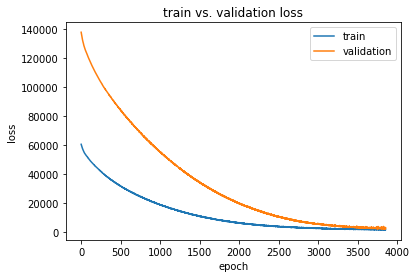

In [0]:
model6 = createModel (input_shape=(x_train6.shape[1], x_train6.shape[2]), units_filter=[100])
history = trainModel_lr(model6, x_train6, y_train, x_valid6, y_valid, x_test6, y_test, min_delta = 50, batch_size = 512, epochs = 4000)
plot_loss(history)

## D.4 Error Analysis

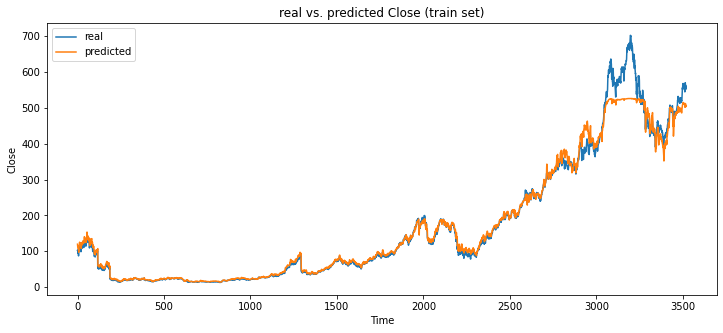

In [0]:
predict_Close_train6, predict_Close_test6 = plot_Close(model6, x_train6, x_test6)

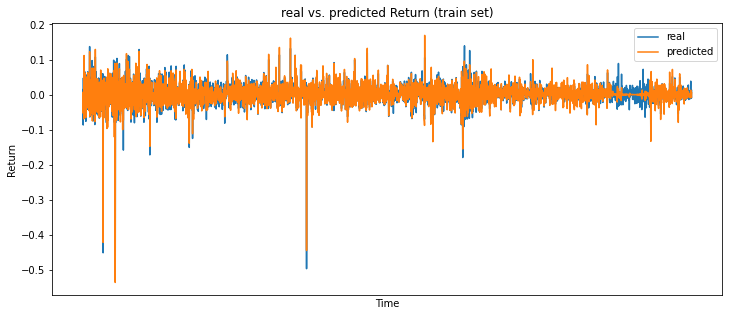

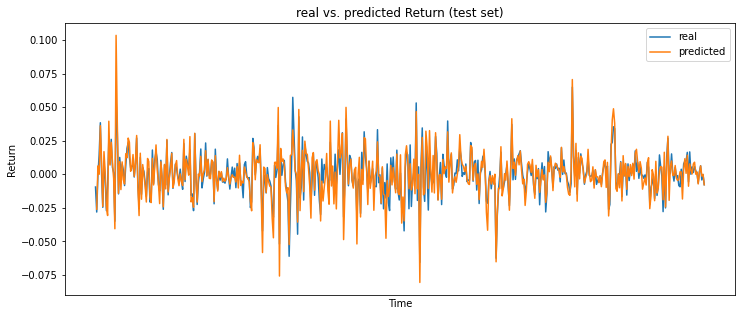

In [0]:
predict_Return_train6, predict_Return_test6 = plot_Return (predict_Close_train6, predict_Close_test6)

**Loss**:
- a relatively small Test MSE loss  
- no overfitting, underfitting or fluctuation
- two loss curves converge to a stable point

**Close**:
- Predicted Close on the training set follows the real Close very well, except for the last peak period. That's the period where the company is paying dividends. As a rare event, it is hard to accurately predict.
Predicted Close on the test set is much closer to the real Close 
- Predicted Close on the test set also follows the real Close very well, although smaller than the real Close. 

**Return**:
- Predicted Return on both training and test sets is better than that in Model3. Model6 is now able to predict extreme return values.


**Model6 is the optimal model so far.**

# Submission guidelines

Here are the basics, a code template that you must complete is in the following cells
- you will be required to store  your model in a file
- you will be required to write a procedure `MyModel` that takes two arguments
    - `test_dir`
        - this is a *relative path* to the holdout data directory
    - `model_path`
        - this is a *relative path* to the file containing your model
- the holdout data directory is similar in structure to the training data directory
    - but without target labels !  It is your job to predict these.
- your procedure must produce predictions given this holdout data directory

This means that your procedure must
- prepare the files in the holdout data directory similar to the way that they were prepared in the training data directory

We will provide you with a sample data directory that will resemble the holdout -- this is so that you
may test the procedure you write for submission.



## Detailed submission guidelines


In **addition to your notebook that trains/evaluates your model**, 
- please also submit an **archive file of the directory** whose name is stored in `model_path`, which 
contains your trained model.
    - use `saveModel` to put your final, trained model in this directory
- We will **not** train your model; we will only use the method `MyModel`
    - which **you** will implement
    - and which uses `loadModel` and the directory whose name is stored in `model_path`
    - this will create the model that we will evaluate


Here is a code template for you to complete
- it will save your model (assuming it is in variable `my_model`)
- it provides the specification for procedure `MyModel`, which *you must complete*


In [0]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # YOUR CODE GOES HERE
    import pandas as pd
    import numpy as np
    
    ## A.1 Get the data: read data for tickers to use 
    tickers_to_use = ['AAPL', 'XLK', 'SPY', 'INTC', 'XLI', 'CSCO']    


    AAPL = pd.read_csv( os.path.join(test_dir, 'AAPL.csv'))
    XLK = pd.read_csv( os.path.join(test_dir, 'XLK.csv'))
    SPY = pd.read_csv( os.path.join(test_dir, 'SPY.csv'))
    INTC = pd.read_csv( os.path.join(test_dir, 'INTC.csv'))
    XLI = pd.read_csv( os.path.join(test_dir, 'XLI.csv'))
    CSCO = pd.read_csv( os.path.join(test_dir, 'CSCO.csv'))

    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids =  [AAPL['Dt'].tail(200)]

    ## Preliminary data prep:
    AAPL['MA7'] = AAPL['Close'].rolling(7).mean()
    AAPL['MA7'] = AAPL['MA7'].shift(1, axis = 0)       
    
    # a list of dataframes
    dfs_to_use = [AAPL, XLK, SPY, INTC, XLI, CSCO] 

    ## create Closes:    
    Close_col = []
    for tick in tickers_to_use:
      Close_col.append (tick + ' Close')
    
    Closes = pd.DataFrame(columns=Close_col)
    for col, df in zip(Close_col, dfs_to_use):
      Closes[col] = df['Close'] 

    ## create x_test6:
    x_test6 = pd.concat([AAPL['MA7'], Closes], axis = 1)
    
    ## C.1 Cleaning:
    for i in range(7):
      x_test6['MA7'][i] = AAPL['Close'][i]
    
    ## C.3 Transformation
    x_test6 = np.array(x_test6).reshape(x_test6.shape[0], 1, x_test6.shape[1])
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predicted_Close = model6.predict(x_test6)[-201:].reshape(201,)
    predicted_Return = pd.DataFrame(predicted_Close).pct_change().drop(index=0)
    predicted_Return = np.array(predicted_Return)

    predictions = [predicted_Return]
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model6 # CHANGE None to your model !

saveModel(my_model, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - directory `data/final_project/stock_prediction`
- we will copy your model file to this directory with the name stored in `model_path`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [0]:
project = "stock_prediction"

holdout_dir = os.path.join(".", "data", "final_project", project, "holdout")
predicts = MyModel(holdout_dir, model_path)

In [0]:
predicts

([array([[ 4.10950184e-03],
         [ 1.42695904e-02],
         [-7.12901354e-03],
         [ 1.38230324e-02],
         [-4.48703766e-03],
         [-2.88438797e-03],
         [ 4.36306000e-04],
         [ 2.17355490e-02],
         [-8.92341137e-04],
         [-2.50130892e-03],
         [-1.71065331e-03],
         [-1.49846077e-04],
         [ 8.55314732e-03],
         [-6.70921803e-03],
         [-4.74113226e-03],
         [-1.08408928e-03],
         [ 1.67965889e-04],
         [-1.04709268e-02],
         [-3.71819735e-03],
         [-2.80654430e-03],
         [ 2.32577324e-03],
         [-2.98529863e-03],
         [-9.96053219e-04],
         [ 1.26192570e-02],
         [ 4.11510468e-03],
         [ 7.39729404e-03],
         [ 2.69758701e-03],
         [-6.53725863e-03],
         [ 8.40187073e-04],
         [ 3.33309174e-04],
         [ 1.69380903e-02],
         [ 1.13166571e-02],
         [-1.47062540e-03],
         [-5.65063953e-03],
         [ 1.79040432e-02],
         [ 2.5673866

In [0]:
print("Done")

Done
